In [356]:
## IMPORTING LIBRARIES

import scipy.special as sp # UNUSED?
import numpy as np # NumPy offers comprehensive mathematical functions, random number generators, linear algebra routines, Fourier transforms, and more
import matplotlib.pyplot as plt # Provides a MATLAB-like way of plotting
import pandas as pd # Data analysis and manipulation tool. Used to read in bathymetry data (M77T file), Directions data (excel file), and organises Vmean into a labelled data structure
# M77T data files are created from raw data collected by marine researchers using InfoBank
from scipy.interpolate import CubicSpline as SP # Used to create a spline about the velocity, shape parameter and proability data
from scipy.optimize import minimize,least_squares,Bounds,basinhopping # Optimizing and route finding
from scipy.special import gamma # Gamma function used for weibull distribution
import matplotlib.cm as cm # UNUSED?
from Boruvka_Mod import Graph # imports class graph from Boruvka_Mod python file
import utm # Used to help convert latitude and longitude in bathymetry data to centred eastings and northings
import scipy.interpolate as spline # Used to smooth the bathymetry data
from matplotlib.colors import ListedColormap # UNUSED?
import math # Provides access to the mafthematical functions
from time import perf_counter # Returns the float value of time in seconds. Used to record run time for clustering and optimization algorithms
from minmax_kmeans import minsize_kmeans # imports minsize_kmeans function from minmax_kmeans python file
import pulp #Used in the clustering algorithm to generate MPS and LP files
import scipy.signal as signal 
from scipy.signal import savgol_filter
from scipy.interpolate import make_interp_spline, BSpline
from scipy.spatial import ConvexHull
from GP_functions1 import GP_train, GP_predict

In [357]:
# KEY PARAMETERS USED THROUGHOUT MODEL

a = 200 # minimum distances turbines can be from one another in m.
b = 3000 # distance that turbines have negligible affect on eachother in m. If model changes this value could change

maximumturbinespertree = 10 # number of turbines allowed along a single cable from the substation.
budget = np.float64(500000000) # Budget in £ to build the wind farm, accounting for construction costs.
DistanceToShore = 15000 # m #distance of the wind farm from shore
TooCloseShore = 5000 # m # minimum distance the wind farm must be from shore
xCoordOnshoreSub = 0 # x coordinate of the onshore substation (y coordinate is -(DistanceToShore))

USDtoGBP = 1/1.351  
EURtoGBP = 1/1.19

IACableCostperMeter = 409.2*EURtoGBP
ExportCableCostperMeter = 833.625*EURtoGBP

CostperTurbineUSD = np.float64(3000000) # USD
CostperTurbine = CostperTurbineUSD*USDtoGBP # GBP

OperatingandMaintenanceCostsperAnnum = np.float64(65500) # GBP
LifeTimeTurbineOperatingTime = 20 # years 120000 # hours
MaintenanceCostperTurbine = OperatingandMaintenanceCostsperAnnum*LifeTimeTurbineOperatingTime # in GBP

LandCostperHectare = 17245 # in GBP
LandCostpermSquared = LandCostperHectare/10000 #  in GBP

OffshoreSubstationCostperMW = np.float64(104000*EURtoGBP)
OnshoreSubstationCostperMW = np.float64(87250*EURtoGBP)
# Costs  associated with the purchase and installation of electrical substations as well as the buildings required for housing the staff and additional equipment required for the running of the wind farm.

ElectricityCostperkWh = 0.144 # 14.4 pence - £0.144
DiscountRate = 0.07 # 7%

TurbineRating = 2 #2MW

GravityBase = 409000*EURtoGBP*TurbineRating #409000euro/MW
Monopile = 551000*EURtoGBP*TurbineRating
Jacket = 665000*EURtoGBP*TurbineRating
TensionLeg = 1163000*EURtoGBP*TurbineRating

In [358]:
#READING IN BATHYMETRY DATA
data = pd.read_csv("nsea86.m77t", sep='\t') # Reads in all data from file including depth data, lattitude, longitude etc.
mindepth = min(data['CORR_DEPTH']) # Retrieves minimum depth value from data file 'nsea86.m77t'    
print('Shallowest depth:', mindepth, 'm') #Prints out the result for the smallest depth value

Shallowest depth: 17.2 m


In [359]:
###CALCULATES THE INITIAL NUMBER OF TURBINES THE OPTIMISATION SHOULD START WITH.    
maxnodespertree = maximumturbinespertree # As above
minareaperturbine = (1/2)*(math.sqrt(3))*(a**2) # Area per turbine assuming 350m between each turbine
LandCostperTurbine=minareaperturbine*(LandCostpermSquared) # Cost with minimum area
MinDepthCostPerTurbine = CostperTurbine*(0.0002*(float(mindepth)**2) - 0.0002*(float(mindepth)) + 0.9459)-CostperTurbine # Uses shallowest depth from before
print('Min depth cost per turbine = £',MinDepthCostPerTurbine) # prints result
MinIACableCostPerTurbine = a*IACableCostperMeter
MinExportCableCost = TooCloseShore*ExportCableCostperMeter # minimum export cable cost with respect to the minimum distance the wind farm must be form shore
MinFoundationCostPerTurbine = GravityBase*TurbineRating

MinCostperTurbTot = CostperTurbine+LandCostperTurbine+MaintenanceCostperTurbine+MinDepthCostPerTurbine+MinIACableCostPerTurbine+MinFoundationCostPerTurbine # Total costs (excluding export cable and fixed costs)
nnturb = (budget-MinExportCableCost)/MinCostperTurbTot 
FixedCost = (OffshoreSubstationCostperMW+OnshoreSubstationCostperMW)*nnturb*TurbineRating # *2 due to 2MW turbines being used *0.4 for assuming 40% effciency
nturb = (budget-FixedCost-MinExportCableCost)/(MinCostperTurbTot) # Turbines possible with current budget
nturb = math.floor(nturb) # rounds down as cannot have fraction of a turbine
minarea = minareaperturbine*nturb # Overall minimum area considering the amount of turbines
maxarea = nturb*(1/2)*(math.sqrt(3))*(b**2) # Careful this isn't bigger than the entire size of the scaled nsea86 sea floor.

print('Min area per turbine =', minareaperturbine, 'm^2') # prints results
print('Min area =', minarea, 'm^2')
print('Max number of turbines =', nturb)
print('Max area =', maxarea, 'm^2')

Min depth cost per turbine = £ 3615.099925980903
Min area per turbine = 34641.016151377546 m^2
Min area = 3186973.4859267343 m^2
Max number of turbines = 92
Max area = 717069034.3335152 m^2


In [360]:
#PRE-OPTIMISATION TURBINE POSITIONING

# places substation at (0,0).
# places 1st turbine at vector (a,0) from substation. a=350m from before
# places 2nd turbine at vector (0.5a,0.5aroot3) from prev. 
# places 3rd turbine at vector (-a,0) from prev
# places 4th turbine at vector (-0.5a,-0.5aroot3) from prev, continues in this spiralling fashion

positionlist = np.empty((nturb+1,2)) # Creates an empty list of size (number of turbines + 1 (since 0 position is substation),2)
turbineposition = np.array([[0,0]]) # Creates [0,0] array for introducing [x,y] coordinates for each turbine
positionlist[0,:] = turbineposition # 

oddcounter = 0
evencounter = 0
i = 0
k = 0

while k<nturb+1: # Loops for number of turbines 
    i += 1
    if (i%2)!= 0: # i is odd
        oddcounter+=1
        for j in range(oddcounter):
            k += 1
            if k == nturb+1:
                break
            if (oddcounter%2)!= 0: #oddcounter is odd
                shift = np.array([[a, 0]])
            else:
                shift = np.array([[-a, 0]])
            turbineposition = np.add(turbineposition, shift)
            positionlist[k,:] = turbineposition
        
    else:
        evencounter+=1
        for j in range(evencounter):
            k += 1
            if k == nturb+1:
                break
            if (evencounter%2)!= 0: #evencounter is odd
                shift = np.array([[0.5*a,0.5*a*math.sqrt(3)]])
            else:
                shift = np.array([[-0.5*a,-0.5*a*math.sqrt(3)]]) 
            turbineposition = np.add(turbineposition, shift)
            positionlist[k,:] = turbineposition
                
print(positionlist) # prints positions data        
print(len(positionlist)) # prints length of positions list (should be the number of turbines + 1 for the subsation)

[[ 0.00000000e+00  0.00000000e+00]
 [ 2.00000000e+02  0.00000000e+00]
 [ 3.00000000e+02  1.73205081e+02]
 [ 1.00000000e+02  1.73205081e+02]
 [-1.00000000e+02  1.73205081e+02]
 [-2.00000000e+02  0.00000000e+00]
 [-3.00000000e+02 -1.73205081e+02]
 [-1.00000000e+02 -1.73205081e+02]
 [ 1.00000000e+02 -1.73205081e+02]
 [ 3.00000000e+02 -1.73205081e+02]
 [ 4.00000000e+02  0.00000000e+00]
 [ 5.00000000e+02  1.73205081e+02]
 [ 6.00000000e+02  3.46410162e+02]
 [ 4.00000000e+02  3.46410162e+02]
 [ 2.00000000e+02  3.46410162e+02]
 [ 0.00000000e+00  3.46410162e+02]
 [-2.00000000e+02  3.46410162e+02]
 [-3.00000000e+02  1.73205081e+02]
 [-4.00000000e+02  0.00000000e+00]
 [-5.00000000e+02 -1.73205081e+02]
 [-6.00000000e+02 -3.46410162e+02]
 [-4.00000000e+02 -3.46410162e+02]
 [-2.00000000e+02 -3.46410162e+02]
 [ 0.00000000e+00 -3.46410162e+02]
 [ 2.00000000e+02 -3.46410162e+02]
 [ 4.00000000e+02 -3.46410162e+02]
 [ 5.00000000e+02 -1.73205081e+02]
 [ 6.00000000e+02  0.00000000e+00]
 [ 7.00000000e+02  1

In [361]:
# Shoreline implementation

XShoreLine = np.array([np.linspace(min(positionlist[:,0])-2500,max(positionlist[:,0])+2500,1000)]) #Creates x coordinates of shoreline bewtween min and max turbine locations +/- 1000m # 1000 data points
YShoreLine = np.array([np.linspace(-DistanceToShore,-DistanceToShore,1000)]) #Creates y coordinates of shoreline at -(distance of the wind farm from the shore) # 1000 data points
TXShoreLine = np.transpose(XShoreLine) #transpose of x coordinates
TYShoreLine = np.transpose(YShoreLine) #transpose of y coordinates
TShoreLine = np.concatenate((TXShoreLine,TYShoreLine),axis=1) # Shoreline (x,y)

In [362]:
# Finds distance between substation and shore

def Substation_To_Shore_Connection(positionlist):
    
    OnshoreSubstation = [xCoordOnshoreSub,-DistanceToShore] # Determines fixed position of onshore substation
    ExportDistance = np.sqrt(((positionlist[0,0]-OnshoreSubstation[0])**2)+((positionlist[0,1]-OnshoreSubstation[1])**2)) # min Hypotenuse for distances between substations
    
    return OnshoreSubstation,ExportDistance

OnshoreSubstation,ExportDistance = Substation_To_Shore_Connection(positionlist) #Initially Executes algorithm

print(OnshoreSubstation)
print(np.shape(OnshoreSubstation))
print(ExportDistance)

[0, -15000]
(2,)
15000.0


In [363]:
# Pushes wind farm further out if the smallest distance between the shore and center of wind farm is too small
# Only used for the pre-optimised layout
#In terms of keeping it this way there are bounds on (minimize(targetfunction, initial guess, bounds,.....etc.) the optimization function

CloseTurbY = min(positionlist[:,1]) # y coordinate of closest turbine
CloseTurbYindex = np.argmin(positionlist[:,1]) # index from closest turbine on y axis
CloseTurbX = positionlist[CloseTurbYindex,0] # x coordinate of closest turbine on y axis
DistanceToMinTurb = min(np.sqrt((CloseTurbX-TXShoreLine[:,0])**2+(CloseTurbY-TYShoreLine[:,0])**2)) #min distance from shore to closest turbine 
s = 0

if DistanceToMinTurb < TooCloseShore: # if closest turbine is too close to the shore
    for s in range(0,nturb+1): # loops for number of turbines plus the substation
        positionlist[s,1] = positionlist[s,1] + (TooCloseShore-DistanceToMinTurb)
        # Shifts entire wind farm up by the difference to achieve the minimum distance required
    Substation_To_Shore_Connection(positionlist) #Calls function to redo substation to shore connection with new values

(-16692.82032302755, -792.8203230275508)

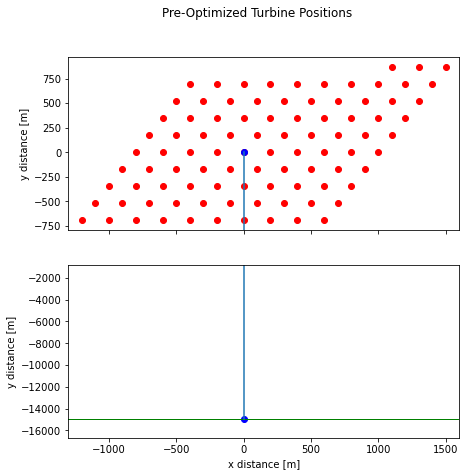

In [364]:
# Display pre-optimized turbine positions before clustering and MST

fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(7,7))
fig.suptitle('Pre-Optimized Turbine Positions')

#Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)    
ax1.scatter(positionlist[:,0],positionlist[:,1],c='red') # Prints turbine positions in red
ax1.scatter(positionlist[0,0],positionlist[0,1],c='blue') # offshore Substation
ax1.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax1.set_ylabel('y distance [m]') # y axis label
ax1.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax1.set_ylim([min(positionlist[:,1])-100, max(positionlist[:,1])+100]) #y limits 

#Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
ax2.scatter(OnshoreSubstation[0],OnshoreSubstation[1],c='blue') #onshore substation
ax2.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
ax2.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax2.set_xlabel('x distance [m]') # x axis label
ax2.set_ylabel('y distance [m]') # y axis label
ax2.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-1000, min(positionlist[:,1])-100]) #y limits

In [365]:
#Function to determine land cost of wind farm using a convex hull
#Calcualtes area of wind farm, onshore substation, and export cable
#Won't work for just 1 turbine since no boundary to enclose

def LandAreaCost(positionlist,ExportDistance):
    
    radius = 130 #m
    OnshoreSubLand = np.pi*radius**2 #Land area associated with the onshore substation
    ExportLand = ExportDistance*8 # Length*width 
    
    hull = ConvexHull(positionlist) #computes convex hull using the turbine positions
    LandArea = hull.volume + OnshoreSubLand + ExportLand #Calcualtes convex hull area and adds on the onshore substation land area

    LandCost = LandArea*LandCostpermSquared
    
    return LandCost

LandCost = LandAreaCost(positionlist,ExportDistance)

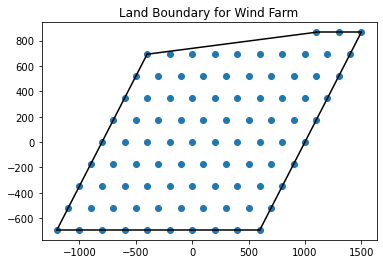

In [366]:
#Visual aid for convex hull plotting

hull = ConvexHull(positionlist)
plt.plot(positionlist[:,0], positionlist[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(positionlist[simplex, 0], positionlist[simplex, 1], 'k-')


plt.title('Land Boundary for Wind Farm')
plt.show()

 C:\Users\adamb\anaconda3\lib\site-packages\pulp\pulp.py:1352: UserWarning:Spaces are not permitted in the name. Converted to '_'


Function run time: 0.7574682000558823
[[   0   12   29   30   31   32   54   58   59 -100 -100]
 [   0   55   56   57   87   88   89   90   91   92 -100]
 [   0    4   16   17   36   37   38   64   65   66   67]
 [   0    1    2    3    8    9   10   11   13   26   27]
 [   0   41   42   43   69   70   71   72   73   74 -100]
 [   0   24   25   47   48   49   50   79   80   81   82]
 [   0   21   22   23   44   45   46   75   76   77   78]
 [   0    5    6    7   18   19   20   39   40   68 -100]
 [   0   14   15   33   34   35   60   61   62   63 -100]
 [   0   28   51   52   53   83   84   85   86 -100 -100]]


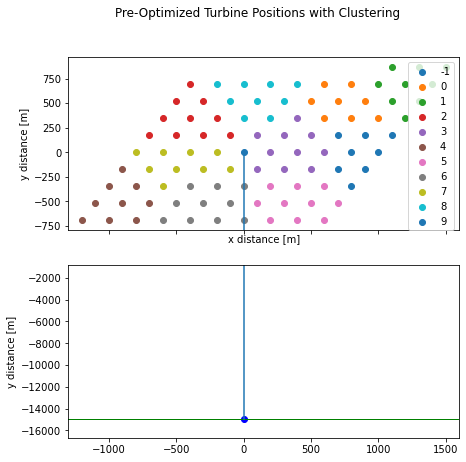

In [367]:
#CLUSTERING ALGORITHM

#Uses an adapted version of kmeans with a cap on the number of points per cluster. Used to radially cluster turbines
#into segments which MST algorithm can then use to determine cabling for a given radial array. Initially unnecessary
#for the initially structured turbine layout as seen above, but increasingly important as turbine layout becomes
#non-uniform through optimisation when the below function is repeatedly called.
# minsize_kmeans imported from external python file

def clustering_algorithm(positionlist,nturb,maxnodespertree):
    k = math.ceil(nturb/maxnodespertree) #number of clusters. math.ceil rounds a number upwards to its nearest integer
    [turbines, centres] = minsize_kmeans(positionlist[1:,:] ,k ,min_size = 1, max_size = maxnodespertree) 
    #turbines exists as an array containing the cluster value for each turbine
    #Assigns each turbine to a cluster. excludes substation, executes external python file, 
    #limits for how many turbines are in each cluster between 1 and max nodes per tree 
    label = np.concatenate((np.array([-1]),turbines)) # Adds -1 (substation label) to the other turbine labels
    u_labels = np.unique(label) 
    # finds unique elements of label. Finds the unique cluster labels 
    # each turbine is assigned a cluster/label and this returns a single label for each cluster
    
    a = 0
    indiceslist = np.empty((k,maxnodespertree), dtype=np.int8) # empty array of no.clusters by max nodes per tree
# indiceslist basically tells us what turbines belong to each cluster
# each row of indiceslist represents a cluster and each point on that row a indidual turbine within that cluster
# Each row starts with a 0 which represents the subsation which belongs to all clusters
# As seen before in the initial layout numbers are assigned starting at 1 which is the turbine (a,0) from the substation
# The numbering then continues in a cyclic motion traveling anticlockwise up until the total number of turbines
    
    for i in range(k): # loops for number of clusters
        indices = [i for i, x in enumerate(label) if x == a] # enumerate exists as a counter in the loop (starts at x=a=0)

        if len(indices) < maxnodespertree:
            noofemptys = maxnodespertree - len(indices)
            for l in range(noofemptys): # For the empty spaces in the matrix replaces these with -100 as fillers
                indices.append(int(-100))
    
        indiceslist[i,:] = (indices)
        a += 1
    
    arr = np.zeros((k,1),dtype=np.int8)   # zero array of number of clusters by 1 (Substation array)
    indiceslist = np.concatenate((arr,indiceslist),axis=1) # Adds substation zero array to turbine cluster matrix
    return indiceslist,u_labels,label

t1_start = perf_counter() # Starts timer
indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree) #Executes clustering algorithm
t1_stop = perf_counter() # Ends timer
print('Function run time:', t1_stop-t1_start) # Prints algorithm run time

fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(7,7))
fig.suptitle('Pre-Optimized Turbine Positions with Clustering')

#Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
for i in u_labels: # loops for number of turbines
    ax1.scatter(positionlist[label == i , 0] , positionlist[label == i, 1] , label = i)
ax1.legend() # prints legend
ax1.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax1.set_xlabel('x distance [m]') # x axis label
ax1.set_ylabel('y distance [m]') # y axis label
ax1.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax1.set_ylim([min(positionlist[:,1])-100, max(positionlist[:,1])+100]) #y limits 

#Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
ax2.scatter(OnshoreSubstation[0],OnshoreSubstation[1],c='blue') #onshore substation
ax2.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
ax2.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax2.set_ylabel('y distance [m]') # y axis label
ax2.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-1000, min(positionlist[:,1])-100]) #y limits

print(indiceslist)

In [368]:
#CREATES INPUT NEEDED FOR MST ONCE CLUSTERS ARE DEFINED.

#distance_global - distances of each turbine with respect to the substation and each other h=sqrt(x^2+y^2)
#e.g. row 0 would be each turbines distance with respect to the substation
# and row 4 would be each turbines distance with respect to the 4th turbine as found in the position list
# distance_globl[i,i] = 1e10 since this is the distance of each turbine with respect to itself so we want the MST to ignore thse values
#angle_global - angle of each turbine with respect to the substation and each other arctan(y/x)
#distance and angle then do something similar but considering the cluster formations as well

def geom_analysis(positionlist,indiceslist):
    
    #Arrays for pairwise distances and angles
    #Angle 0: x directıon. Angle pi/2: y directıon
    distance = [None] * math.ceil(nturb/maxnodespertree) # null array with size based on number of clusters
    angle = [None] * math.ceil(nturb/maxnodespertree) 
    distance_global = np.zeros((nturb,nturb)) #zero array nturb by nturb. This will be for storing the distance between each pair of turbines for cabling
    angle_global = np.zeros((nturb,nturb)) # Like above this will be for storing the angle data between each pair of turbines for cabling
    coords = positionlist[1:,:] # Coordinates of each turbine

    for i in range(0,nturb): # loops for number of turbines
        distance_global[i,:]=np.sqrt(np.square(coords[i,0]-coords[:,0])+np.square(coords[i,1]-coords[:,1])) # Pythagoras for hypotenuse
        angle_global[i,:]=np.arctan2(coords[:,1]-coords[i,1],coords[:,0]-coords[i,0]) #Pythagoras for angle
        distance_global[i,i]=1e10
        #Rotate angles so that north=0 and convert to degrees
    angle_global=-np.rad2deg(angle_global)+270
    
    for x in range(0,math.ceil(nturb/maxnodespertree)): # loops for number of clusters
        nturbintree = np.count_nonzero(indiceslist[x,:] > -1) # Everything except the -100 ones which were denoted earlier to show that there is no turbine at that index
        distance[x]=np.zeros((nturbintree,nturbintree))
        angle[x]=np.zeros((nturbintree,nturbintree))
    
        for i in range(0,nturbintree):
            for j in range(0,nturbintree):
                distance[x][i,j] = np.sqrt(np.square(positionlist[(indiceslist[x,i]),0]-positionlist[(indiceslist[x,j]),0]) + np.square(positionlist[(indiceslist[x,i]),1]-positionlist[(indiceslist[x,j]),1]))
                angle[x][i,j]=np.arctan2(positionlist[(indiceslist[x,j]),1]-positionlist[(indiceslist[x,i]),1],positionlist[(indiceslist[x,j]),0]-positionlist[(indiceslist[x,i]),0])
                distance[x][i,i]=1e10
        
        #Rotate angles so that north=0 and convert to degrees
        angle[x]=-np.rad2deg(angle[x])+270
      
    return distance,angle,distance_global,angle_global

In [369]:
# DETERMINES MINIMUM LENGTH OF CABLING REQUIRED TO CREATE COMPLETE CABLING NETWORK SUCH THAT ALL TURINES ARE CONNECTED
# IN ACCORDANCE WITH USER'S CONDITIONS.

def Minimum_Spanning_Tree(distance,indiceslist):

    MSTweight = [None] * math.ceil(nturb/maxnodespertree) # null array with sized based on number of clusters
   
    for x in range(0,math.ceil(nturb/maxnodespertree)): #loops for number of clusters
        nturbintree = np.count_nonzero(indiceslist[x,:] > -1)
        g=Graph(nturbintree) #Graph is part of the external python script titled Boruvka_Mod
        
        for i in range(0,nturbintree):
            for j in range(i+1,nturbintree):
                g.addEdge(i,j ,(distance[x][i,j]*1000))
           
        MSTweight[x]=g.boruvkaMST()
    return MSTweight

Each tree weight tree 1 2092820.323027551
Each tree weight tree 2 2816552.506059644
Each tree weight tree 3 2000000.0
Each tree weight tree 4 2000000.0
Each tree weight tree 5 2471779.7887081346
Each tree weight tree 6 2199999.9999999995
Each tree weight tree 7 2146410.161513775
Each tree weight tree 8 1800000.0
Each tree weight tree 9 1946410.1615137754
Each tree weight tree 10 2121110.255092798
MST total weight 21595083.195915677 m


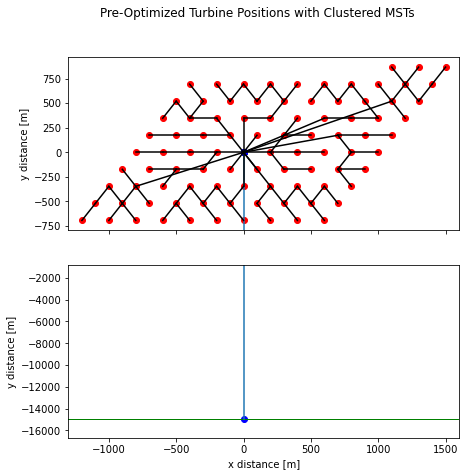

In [370]:
#PLOTTING PRE-OPTIMISED MST

# the Boruvka_mod code requires graphs with vertices 0....n, which is provided by the index value on indices list.
# When this is plotted, the values within the correct indiceslist row are then used to reference the index within
# positionlist to be plotted.

#

MSTweight=Minimum_Spanning_Tree(geom_analysis(positionlist, indiceslist)[0],indiceslist)

fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(7,7))
fig.suptitle('Pre-Optimized Turbine Positions with Clustered MSTs')

#Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
ax1.scatter(positionlist[:,0],positionlist[:,1],c='red') # Prints turbine positions in red
ax1.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax1.set_ylabel('y distance [m]') # y axis label
ax1.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax1.set_ylim([min(positionlist[:,1])-100, max(positionlist[:,1])+100]) #y limits 

#Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
ax2.scatter(OnshoreSubstation[0],OnshoreSubstation[1],c='blue') #onshore substation
ax2.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
ax2.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax2.set_xlabel('x distance [m]') # x axis label
ax2.set_ylabel('y distance [m]') # y axis label
ax2.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-1000, min(positionlist[:,1])-100]) #y limits

links = [None] * math.ceil(nturb/maxnodespertree)
MSTWeightSum = 0 #MST weight is simply the total length of cabling used

for a in range(0,math.ceil(nturb/maxnodespertree)):
    MSTWeightSum += MSTweight[a][0]
    print('Each tree weight', 'tree',a+1 ,MSTweight[a][0])
    links[a] = MSTweight[a][1]
    
    for b in links[a]:
        u = positionlist[(indiceslist[a,b[0]])][0], positionlist[(indiceslist[a,b[1]])][0]
        v = positionlist[(indiceslist[a,b[0]])][1], positionlist[(indiceslist[a,b[1]])][1]
        ax1.plot(u,v, c='black')
        ax1.scatter(positionlist[0,0],positionlist[0,1],c='blue')
        
print('MST total weight', MSTWeightSum, 'm')

In [371]:
#DISPLAYS RAW BATHYMETRY DATA

#print(data) # Prints out bathymetry data - Read in using pandas in previous section

In [372]:
#CONVERTS LATITUDE AND LONGITUDE IN BATHYMETRY DATA TO CENTERED EASTINGS AND NORTHINGS

data['easting'] = data.apply(lambda row: utm.from_latlon(row['LAT'], row['LON'])[0], axis=1) #Converts lon/lat to easting and adds this onto the 'data' file
data['northing'] = data.apply(lambda row: utm.from_latlon(row['LAT'], row['LON'])[1], axis=1) #Converts lon/lat to northing and adds this onto the 'data' file

zero_east = min(data['easting']) + (max(data['easting']) - min(data['easting']))/2 +30000 # Determines centre of bathymrtry data in easting direction (+30,000 is simply to get a more interesting result from the current bathymetry data)
zero_north = min(data['northing']) + (max(data['northing']) - min(data['northing']))/2 # Determines centre of bathymetry data in northing direction   

data['centered_easting'] = data['easting'] - zero_east # Centres the data about (0,0) and adds this onto the 'data' file
data['centered_northing'] = data['northing'] - zero_north # Centres the data about (0,0) and adds this onto the 'data' file

#print(data) 

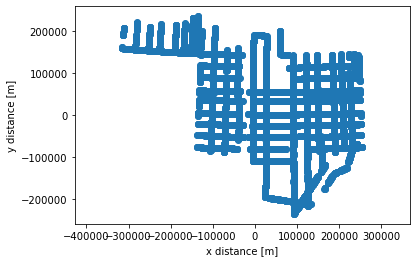

In [373]:
#PLOTS CENTERED BATHYMETRY DATA

fig, ax = plt.subplots()
plt.axis('equal')
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
ax.scatter(data['centered_easting'],data['centered_northing'])
plt.show()

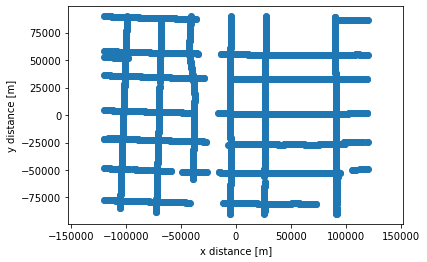

In [374]:
# SAMPLING AND PLOTTING CENTRAL BATHYMETRY DATA
# Takes sample between +/-120000 in easting direction, +/-90000 in the northing direction, and +/-1000 for the depth values

fig, ax = plt.subplots()
plt.axis('equal')
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
data = data[(data['centered_easting'] >=-120000) & (data['centered_easting'] <= 120000) & (data['centered_northing']>=-90000) & (data['centered_northing']<= 90000) & (data['CORR_DEPTH']<=1000) & (data['CORR_DEPTH']>=-1000)]
ax.scatter(data['centered_easting'],data['centered_northing'])
plt.show()

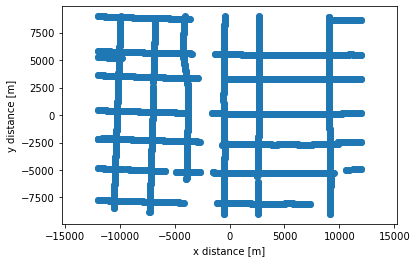

In [375]:
#FURTHER BATHYMETRY DATA PROCESSING
#Further decreases the area considered to be more applicable to the size of the wind farm (Sample from before divided by 10 in northing and easting directions)

fig, ax = plt.subplots()
plt.axis('equal')
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
data['centered_easting'] = data['centered_easting']/10
data['centered_northing'] = data['centered_northing']/10
ax.scatter(data['centered_easting'],data['centered_northing'])
plt.show()

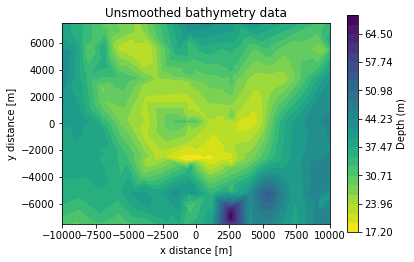

In [376]:
#UNSMOOTHED BATHYMETRY DATA CONTOUR PLOTTING

fig, ax = plt.subplots()
plt.xlim([-10000, 10000]) # x Limits of plot between +/-10000
plt.ylim([-7500, 7500]) # y Limits of plot between +/-7500
ax.set_aspect(aspect=1) # Sets the aspect of the axis scaling, i.e. the ratio of y-unit to x-unit.
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')

maxdepth = max(data['CORR_DEPTH'])
levels = np.linspace(mindepth,maxdepth,24) # Creates 24 even spaces or levels between the min and max depth

tcf = ax.tricontourf(data['centered_easting'], data['centered_northing'], data['CORR_DEPTH'], levels=levels, cmap = 'viridis_r') # (x,y,colour bar factor,level values,colour scale)
cbar = plt.colorbar(tcf)
cbar.set_label('Depth (m)')
ax.set_title('Unsmoothed bathymetry data');

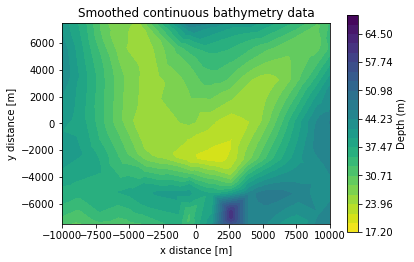

In [377]:
#SMOOTHING BATHYMETRY DATA

smooth = spline.SmoothBivariateSpline(data['centered_easting'], data['centered_northing'], data['CORR_DEPTH'], s = 25000)

fig, ax = plt.subplots()
plt.xlim([-10000, 10000])
plt.ylim([-7500, 7500])
ax.set_aspect(aspect=1)
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
levels = np.linspace(mindepth,maxdepth,24)

tcf = ax.tricontourf(data['centered_easting'], data['centered_northing'], smooth(data['centered_easting'], data['centered_northing'], grid=False), levels=levels, cmap = 'viridis_r')
cbar = plt.colorbar(tcf)
cbar.set_label('Depth (m)')
ax.set_title('Smoothed continuous bathymetry data');

In [378]:
# DETERMINING DEPTH AND ASSOCIATED COST FOR EACH TURBINE

def depthvalues(positionlist):
    DepthPerTurbine = [None] * (len(positionlist)-1) # none defines a null/no value. Get a null list the size of the np. turbines
    DepthCostPerTurbine = [None] * (len(positionlist)-1) # Get a null list the size of the number of turbines
    DepthCostAllTurbines = np.float64(0) # Assigns initial value to variable

    for i in range(0,len(positionlist)-1): # loops for amount of turbines
        DepthPerTurbine[i] = spline.SmoothBivariateSpline.ev(smooth, positionlist[i+1,0], positionlist[i+1,1]) # Acquires depth assigned to each turbines position (x,y)
        DepthCostPerTurbine[i] = MinDepthCostPerTurbine = CostperTurbine*(0.0002*(float(DepthPerTurbine[i])**2) - 0.0002*(float(DepthPerTurbine[i])) + 0.9459)-CostperTurbine #Formula for depth cost
        DepthCostAllTurbines += DepthCostPerTurbine[i] # Sums up all turbines depth costs
        
    mindepth=float(min(DepthPerTurbine))
    maxdepth=float(max(DepthPerTurbine))
    return DepthCostAllTurbines, mindepth, maxdepth # returns respective values to user

depthvalues(positionlist)

(14613370.971835075, 23.36918326527576, 27.167705077146056)

In [379]:
smooth

In [380]:
#SETTING MODEL PARAMETERS

v0=8.0  #Incoming wind speed
nwind = 33
wind=np.arange(254,287)

#b=np.array((1,5,1000))
#b=np.array(( 1.40002561e-01,   8.51478121e+00,   2.62606729e+03))

# 3 model parameters below:

# 0th: how much power the turbine removes at the centre of the peak of the power distribution.
# 1st: how wide the angle of effect is. UNITS: degrees
# 2nd: up to how far back the effect takes place (approx. 2.6km) UNITS: [m]

model=np.array((1.39998719e-01, 8.51483871e+00, 2.62613638e+03))

ws=2.0 #weibull scale factor
wei_gamma=gamma(1.+1./ws)

Pr = 2*10**6 #Rated Power for Horns Rev 1 Turbines. Max power output [Watts]
Vc = 4.0 #Cut-in Velocity. Starts producing energy at wind speed of 4m/s [m/s]
Vr = 15.0 #Rated Velocity. Starts producing max energy at 15m/s
Vf = 25.0 #Cut-off Velocity. Turbines cut out at wind speeds of 25m/s to prevent damage to the turbines.
k = 2.0 #Weibull shape parameter
(Pr,Vc,Vr,k)

#interpolation parameters
dvel=1.5 #[m/s]
dang=5. #[degrees]

In [381]:
#DETERMINING WIND DIRECTION AND VELOCITY AT HORNS REV 1

v=np.loadtxt('hornsrev_data_all.txt') # assigns data to variable v.
vxref=v[:,3] # (INDEXING STARTS FROM 0). Third column of data is velocity of wind in x direction.
vyref=v[:,4] # (INDEXING STARTS FROM 0). Fourth column of data is velocity of wind in y direction.
angles=v[:,0] # Zeroth column of data is wind angle.
vmean=np.sqrt(np.square(vxref)+np.square(vyref)) # Uses pythagoras to find the wind magnitude + direction for each location.

vmean=pd.DataFrame(vmean) # organises vmean into labelled data structure
vref=pd.DataFrame()

vmean['angle']=angles # add another column to vmean (angle)
vref=vref.append(vmean) # add empty pandas data frame

vref=vref.groupby('angle')
vref.groups
vref.describe()
vref.get_group(260).iat[50,0] # data manipulation to group by angle etc.

6.512913707119303

In [382]:
#Arrays for pairwise distances and angles
#Angle 0: x direction. Angle pi/2: y directıon

# calculates distance and angle between each pair of turbines:

distance=np.zeros((nturb,nturb)) # 2x2 matrix of distances between turbines i and j where distance i-i and distance j-j = 0
# as they're distances to themselves: i-i i-j
                                 #    j-i j-j

angle=np.zeros((nturb,nturb)) # same as above but for angles between turbines.

for i in range(0,nturb):
   
    # 80x80 matrices as there's 80 turbines at Horns Rev 1.
    # squares y distance and x distance then sqrt to find overall distance between 2 turbines.
    distance[i,:]=np.sqrt(np.square(positionlist[i+1,0]-positionlist[1:,0])+np.square(positionlist[i+1,1]-positionlist[1:,1]))
    # same as above using arctan2 whilst giving correct quadrant (between 2 turbines).
    angle[i,:]=np.arctan2(positionlist[1:,1]-positionlist[i+1,1],positionlist[1:,0]-positionlist[i+1,0])
# Rotate angles so that north=0 and convert to degrees (and clockwise instead of anticlockwise)
angle=-np.rad2deg(angle)+270

# Rotating angles to wind direction
windangle=5 # degrees
rotangles=np.mod(angle-windangle+180,360)-180

In [383]:
# IMPORTING WIND DIRECTION DATA

#meteorological data where north = 0 degrees)
directiondata = pd.read_csv ('Directiondata.csv')
print (directiondata)
# velocity is the mean velocity with which wind from this direction blows
# c determines how wide the distribution is
# frequency/100 determines how often the wind is blowing at this angle

    Angle  Velocity     c  frequency
0       0      8.89  2.09       4.82
1      30      9.27  2.13       4.06
2      60      8.23  2.29       3.59
3      90      9.78  2.30       5.27
4     120     11.64  2.67       9.12
5     150     11.03  2.45       6.97
6     180     11.50  2.51       9.17
7     210     11.92  2.40      11.84
8     240     11.49  2.35      12.41
9     270     11.08  2.27      11.34
10    300     11.34  2.24      11.70
11    330     10.79  2.19       9.69
12    360      8.89  2.09       4.82


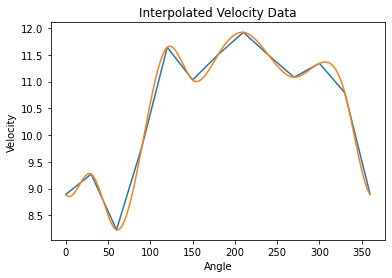

In [384]:
# interpolate 'velocity'
# info is only given every 30 degrees, giving a 'step function'
# interpolation gives higher resolution
# function is periodic as 360deg is the same as 0deg.
x = directiondata['Angle']
y = directiondata['Velocity']
wbvel = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360,0.10)
plt.plot(x,y, label='Line')
plt.plot(xs, wbvel(xs), label="Interpolated line ")
plt.title('Interpolated Velocity Data')
plt.xlabel('Angle')
plt.ylabel('Velocity')
plt.show()
# blue lines shows linear interpolation, orange shows smooth interpolation including across the
# periodic boundary.

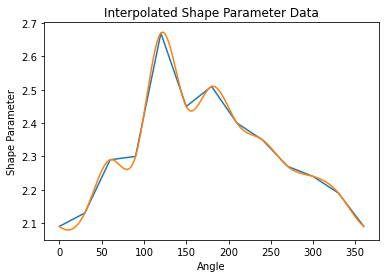

In [385]:
#interpolate 'c'
# info is only given every 30 degrees, giving a 'step function'
# interpolation gives higher resolution
# function is periodic as 360deg is the same as 0deg.
x = directiondata['Angle']
y = directiondata['c']
wbshape = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360, 0.1)
plt.plot(x,y)
plt.plot(xs, wbshape(xs), label="S")
plt.title('Interpolated Shape Parameter Data')
plt.xlabel('Angle')
plt.ylabel('Shape Parameter')
plt.show()

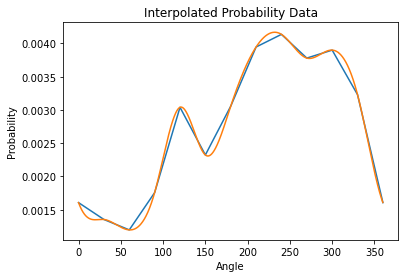

In [386]:
#interpolate 'frequency'
# info is only given every 30 degrees, giving a 'step function'
# interpolation gives higher resolution
# function is periodic as 360deg is the same as 0deg.
x = directiondata['Angle']
y = directiondata['frequency']/(100.*30.) #Data is in percent per 30 degrees, changing to probability per degree


windfreq = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360, 0.1)
plt.plot(x,y)
plt.plot(xs, windfreq(xs), label="S")
plt.title('Interpolated Probability Data')
plt.xlabel('Angle')
plt.ylabel('Probability')
plt.show()
# plot shows wind direction is predominantly 200-320deg.

In [387]:
# Simple Attenuation fn
# Determines how much wind there is AFTER a turbine.
def att(dist, ang, model): 
        # 'Model' parameters are defined in 2ND CELL.

    # angular part
    angular=np.where(2.*model[1]*np.abs(ang)<np.pi,np.square(np.cos(model[1]*ang)),0.)
    # angular = np.cos(model[1]*ang WHEN 2.*model[1]*np.abs(ang) is less than pi, else angular = 0.
    
    # radial part (distance) (Gaussian Function)
    radial=np.exp(-np.square(dist/model[2])) # decreasing exponential of square, scaled by 2nd parameter
    penalty=np.exp(-np.square(dist/200))
    #penalty = 0
    return 1.0-1*model[0]*angular*radial-2*model[0]*penalty # OUTCOME

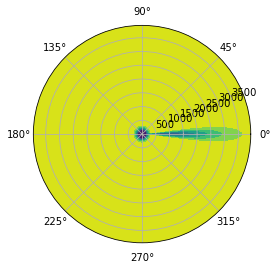

0.580003843


In [388]:
azimuths = np.radians(np.linspace(0, 360, 360)) # angles theta from 0 to 360 degress in 1 degree increments. Grid
zeniths = np.arange(0, 4000, 50) # distance from 0 to 4000 broken up into increments of 50.

r, theta = np.meshgrid(zeniths, azimuths)
values = att(r,np.mod(theta+np.pi,np.pi*2)-np.pi,model) # gets angles from -pi to pi, not from 0 to 2pi.

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
ax.contourf(theta, r, np.maximum(values,0.85*np.ones(np.shape(values))))

plt.show()
print(np.min(values))

## Cell description:
# Polar plot is for 1 turbine, blue area shows where wind speed is affected. (Numbers label distance from turbine).
# Across the curve the distribution is the hump of cosine^2 function.
# Radially the distribution shown is Gaussian.
# Wake is currently too narrow close to the turbine as it treats the turbine as a point rather than accommodating
# for the blades' diameter.

In [389]:
# returning total deviation between model and training set (between CFD data and the attenuation model)
# This was relevant for earlier stages of the project when the wake model was being developed
#Total att
def deviation(b):
    total_att=np.ones((nturb,nwind))
    deviation=0
    for k in range(0,nwind):
        for j in range(0,nturb):
            for i in range(0,nturb):
                if (i!=j):
                    total_att[j,k] = total_att[j,k]*att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-wind[k])+np.pi,np.pi*2)-np.pi,b)
 #           print('{0} {1} {2}'.format(j,wind[k],total_att[j,k]))
            deviation=deviation+np.square(vref.get_group(wind[k]).iat[j,0]-v0*total_att[j,k])
    return deviation

In [390]:
# returning deviation for each turbine.
# This was relevant for earlier stages of the project when the wake model was being developed
#Total att
def deviation_sq(model):
    total_att=np.ones((nturb,nwind))
    dev_vec=np.zeros((nturb*nwind))
    for k in range(0,nwind):
        for j in range(0,nturb):
            for i in range(0,nturb):
                if (i!=j):
                    total_att[j,k] = total_att[j,k]* att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-wind[k])+np.pi,np.pi*2)-np.pi,model)
 #           print('{0} {1} {2}'.format(j,wind[k],total_att[j,k]))
            dev_vec[nturb*k+j]=(vref.get_group(wind[k]).iat[j,0]-v0*total_att[j,k])
    return dev_vec

In [391]:
## (USED IN TARGET FUNC)
# Calculates the power produced by turbines when it sees a certain wind speed at a certain angle. 3D matrix
def power(wsr,v): # wind speed reduction, velocity
    nvel=np.size(v)
    nangle=np.size(wsr,1)
    power_vec=np.zeros((nturb,nangle,nvel))
    power_vec=POvec(np.outer(wsr,v)).reshape(nturb,nangle,nvel) # np.outer takes every wsr element and individually multiplies it with every element of v.
    return power_vec

In [392]:
## GIVES PROBABILITY OF WIND SPEED V AT A GIVEN ANGLE
def windspeedprobability(angles,v,d_angle,d_vel):
    nvel=np.size(v) 
    nangle=np.size(angles)
    wsprob=np.zeros((nangle,nvel))
    for i in range(angles.shape[0]):
        # Get Weibull parameters for angle and evaluate probability
        wsprob[i,:]=(wei(v[:],wbvel(angles[i]),wbshape(angles[i])))*windfreq(angles[i])*d_angle*d_vel
    return wsprob

In [393]:
# DEFINES WEIBULL DISTRIBUTION (shows the probability of any given wind speed occuring).

def wei(x,n,k): # convention to have in this order, scale parameter comes first (x) 
    u=n/gamma(1+1/k) #scaled wind speed
    return (k / u) * (x / u)**(k - 1) * np.exp(-(x / u)**k)
# k = Weibull shape parameter
# n = scale parameter
# x= value we are valuating

In [394]:
def wind_dist(v,vm):
    return wei(v,vm,k)

In [395]:
wind_dist(1.0,v0)

0.024244336764100854

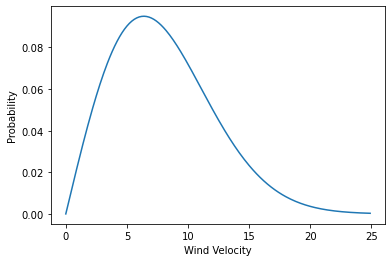

In [396]:
# PLOTS WEIBULL DISTRIBUTION

x=np.arange(0,25,0.1)
y=wind_dist(x,v0)

plt.xlabel('Wind Velocity')
plt.ylabel('Probability')
plt.plot(x,y)

In [397]:
velocities=np.arange(Vc,Vf,dvel) # 1D array ranging from Vc to Vf in dvel intervals. 4 to 25 in steps of 1.5
angles=np.arange(0,360,dang) # 0 to 360 with intervals of dang.
wsp=windspeedprobability(angles,velocities,dang,dvel) # tells probability of getting wind from a certain direction with a certain velocity.
# sum of all numbers would add up to 1.
print(wsp,np.shape(wsp),np.sum(wsp)) # wsp array, shape of wsp (rows,columns), sum of wsp elements
print(np.shape(velocities)) # shape of velocities array (rows, columns)
#plt.plot(x,y)
print(angles)
print(velocities)
print(dang)

[[7.95303494e-04 9.80036676e-04 1.05789271e-03 ... 6.39190809e-05
  3.40253887e-05 1.70630457e-05]
 [7.34767202e-04 9.01764403e-04 9.69915308e-04 ... 5.75583274e-05
  3.06371248e-05 1.53701909e-05]
 [6.87320078e-04 8.44491359e-04 9.10294073e-04 ... 5.77144043e-05
  3.11157981e-05 1.58295009e-05]
 ...
 [9.80182139e-04 1.25683306e-03 1.41621103e-03 ... 1.55577912e-04
  9.05953796e-05 4.99151675e-05]
 [9.27369324e-04 1.17045619e-03 1.29626789e-03 ... 1.10756647e-04
  6.20462178e-05 3.28196113e-05]
 [8.63068120e-04 1.07416013e-03 1.17166708e-03 ... 8.08008629e-05
  4.38237311e-05 2.24068824e-05]] (72, 14) 0.9458659589195532
(14,)
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355.]

In [398]:
# CALCULATES THE POWER CURVE OF A TURBINE

# Plots the power curve of a turbine.
# No power output from 0-4m/s, then cubic rise up to 15m/s and stays
# constant until cut-off velocity of 25m/s.

#cubic Based Power output
a=Pr/(Vr**3-Vc**3)
b=Vc**3/(Vr**3-Vc**3)

def q(v): # q is power output

    if (v<Vc): # below cut in velocity power is 0.
        q=0
    elif (v<Vr):
        q=a*v**3-b*Pr # cubic power output between cut in and max.
    elif (v<Vf):
        q=Pr # max power between max and cut off velocity.
    else: 
        q=0 # no power above cut off velocity.
    return q

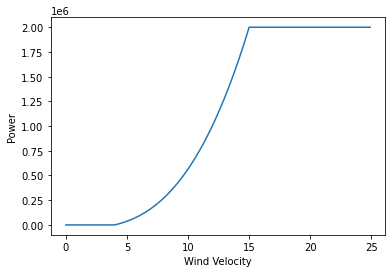

In [399]:
#PLOTS TURBINE POWER CURVE

x=np.arange(0,25,0.1)
POvec=np.vectorize(q) # vectorises power output function q (from cell above).
y=POvec(x)

plt.xlabel('Wind Velocity')
plt.ylabel('Power')
plt.plot(x,y)

In [400]:
# EXPECTED TURBINE OUTPUT (Watts) for the given wind distribution and positions.
# Can be seen that top left (NW) produces most energy for Horns Rev 1 Wind Farm.

# EXPECTED POWER FROM WIND FARM CALCULATIONS
# multiply the power that you'd get for each wind angle and speed condition by the probability of this occuring, for all angles and speed
# values and sum to find the expected power.
# Sum up this value for all turbines to find total wind farm expected power output.
# output=np.zeros((nturb)) 
# output=np.tensordot(powout,wsp,2)
# print(output,np.shape(output),np.sum(output))
# last output is total power output in Watts.

In [401]:
# TURBINE OUTPUT (Watts) WITH NO INTERFERENCE

#Reference output:
# Same calculations as cell above except each turbine sees the full amount of wind every time
# (i.e. no wind reduction from other turbines).
refpowout=power(np.ones((nturb,np.size(angles))),velocities)
refoutput=np.zeros((nturb))
refoutput=np.tensordot(refpowout,wsp,axes=2)
print(refoutput,np.shape(refoutput),np.sum(refoutput))

# last output is total power output in Watts.

[867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.6

In [402]:
# # assigns smaller interpolation intervals to dvel and dang to compare to coarser interpolations.
# dvel=0.1
# dang=0.1
# velocities=np.arange(Vc,Vf+dvel,dvel)
# angles=np.arange(0,360,dang)
# wsp=windspeedprobability(angles,velocities,dang,dvel)
# wsr=windspeedreduction(distance,angle,angles,model)
# powout=power(wsr,velocities)
# output=np.zeros((nturb)) 
# output=np.tensordot(powout,wsp,2)
# print (dvel,dang,np.sum(output))
# fineout=output

In [403]:
# # Calculates RMS error from changing interpolation value.
# velarray=np.array([1.5])
# angarray=np.array([5])
# rmserror=np.zeros((np.size(velarray),np.size(angarray)))
# i=0
# for dvel in velarray:
#     j=0
#     for dang in angarray:
#         velocities=np.arange(Vc,Vf+dvel,dvel)
#         angles=np.arange(0,360,dang)
#         wsp=windspeedprobability(angles,velocities,dang,dvel)
#         wsr=windspeedreduction(distance,angle,angles,model)
#         powout=power(wsr,velocities)
#         output=np.zeros((nturb)) 
#         output=np.tensordot(powout,wsp,2)
#         rmserror[i,j]=np.sqrt(np.sum(np.square(output-fineout))/np.size(output))
#         print (dvel,dang,np.sum(output),rmserror[i,j])
#         j+=1
#     i+=1
# print(rmserror)

In [404]:
## IMPORTING WIND DIRECTION DATA
## north = 0 degrees
direction_data = pd.read_csv('Directiondata.csv')
wind_directions = directiondata['Angle']
wind_directions = pd.DataFrame(wind_directions).to_numpy()
wind_directions = np.transpose(wind_directions)

In [405]:
## FUNCTION: SIMPLE ROTATE
def rotate(angle, coords):
    angle = np.pi*angle/180.
    rot_x_corrds = []
    rot_y_corrds = []
    for coord in coords:
        rot_x_corrds += [coord[0]*np.cos(angle) - coord[1]*np.sin(angle)]
        rot_y_corrds += [coord[0]*np.sin(angle) + coord[1]*np.cos(angle)]
    rot_coords = [rot_x_corrds,rot_y_corrds]
    rot_coords = np.array(rot_coords).T
    return rot_coords

In [406]:
# TRAIN MODEL and assign to predicting class
name = "all_dataset.csv"
training_class = GP_train() # create training class
training_model = training_class.train_model() # trains model on "all_dataset.csv"

# CREATE PREDICTING CLASS from which attenuation predictions are made
predict_class = GP_predict(training_model) # create predicting class

In [407]:
## OLD WINDSPEED REDUCTION FUNCTION (USED IN TARGET FUNC)
## description: calculates the % of wind that arrives at a turbine for a certain angle.
## Starts with assumption that there's zero wake so all turbines get full wind.
def windspeedreduction_old(distance,angle,direction,model): # vectors
    ndir=np.size(direction)
    total_att=np.ones((nturb,ndir)) # as many rows as there are turbines, as many columns as there are wind directions.
 #   power_vec=np.zeros((nturb,ndir))
    for j in range(0,nturb):
        for i in range(0,nturb):
            if (i!=j):
                # compounding wind speed reductions
                total_att[j,:] = total_att[j,:]* att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-direction[:])+np.pi,np.pi*2)-np.pi,model)
  #      power_vec[j,:]=(v0*total_att[j,:])**3
    return total_att # matrix output that's needed. n turbine rows, n direction columns.
                     # Tells how much of 100% of wind arrives at a certain turbine from a certain direction.
    
## TESTING   
distance,angle,distance_global,angle_global = geom_analysis(positionlist,indiceslist)
print(f'OLD WSR')
print(f'positionlist.shape = {positionlist.shape}')

print(f'angles.shape = {angles.shape}     (number of wind angles!)')
wsr=windspeedreduction_old(distance_global,angle_global,angles,model) ## old WSR function
# np.set_printoptions(threshold=np.inf)
# print(f'wsr = \n{wsr}')
# np.set_printoptions(threshold=1000)
print(f'type(wsr) = {type(wsr)}\nwsr.shape = {wsr.shape}\nCONCLUSION: the first dimension (y = {wsr.shape[0]}) is nturb, the second dimension (x = {wsr.shape[1]}) is ndir')

OLD WSR
positionlist.shape = (93, 2)
angles.shape = (72,)     (number of wind angles!)
type(wsr) = <class 'numpy.ndarray'>
wsr.shape = (92, 72)
CONCLUSION: the first dimension (y = 92) is nturb, the second dimension (x = 72) is ndir


In [408]:
## FUNCTION: WIND SPEED REDUCTION (WSR) (NEW!)
## description: returns a matrix of wind attenuation with nturb turbine rows, ndir direction columns
def windspeedreduction(positionlist,directions,g_model):
    ndir = int(np.size(directions))
    nturb = int(np.size(positionlist)/2)
    total_att=np.ones((nturb,ndir))
    for i in range(0,ndir):
        angle_to_rotate = 90 + directions[i];
        westerly_pos_list = rotate(angle_to_rotate,positionlist) # rotate position list for westerly wind
        att_vector = g_model.predict(westerly_pos_list, nturb) # vector of attenuations (from GP_functions module)
        att_vector = att_vector.reshape(nturb,)
        total_att[:,i] = att_vector
    total_att = total_att/8 ## Get attenuation as a fraction compared to the assumed base wind speed in gaussian model of 8 m/s
    return total_att

## TESTING
wind_directions_for_WSR = wind_directions[0]
print('NEW WSR')
wsr=windspeedreduction(positionlist[1:,:],angles,predict_class) ## new WSR function ## the "turbine" at origin is substantion and hence removed
print(f'positionlist.shape = {positionlist.shape}')
print(f'wind_directions_for_WSR.shape = {wind_directions_for_WSR.shape}     (number of wind angles!)')
print(f'type(wsr) = {type(wsr)}\nwsr.shape = {wsr.shape}\nCONCLUSION: the first dimension (y = {wsr.shape[0]}) is nturb, the second dimension (x = {wsr.shape[1]}) is ndir')

NEW WSR


 C:\Users\adamb\OneDrive - University of Warwick\University Documents\3rd Year\ES327 Individual Project\Wind-Farm-Layout-Gaussian-Optimisation\three_desc_model.py:335: RuntimeWarning:invalid value encountered in arccos


positionlist.shape = (93, 2)
wind_directions_for_WSR.shape = (13,)     (number of wind angles!)
type(wsr) = <class 'numpy.ndarray'>
wsr.shape = (92, 72)
CONCLUSION: the first dimension (y = 92) is nturb, the second dimension (x = 72) is ndir


In [409]:
powout=power(wsr,velocities); # total output power
output=np.tensordot(powout,wsp,axes=2);

 C:\Users\adamb\anaconda3\lib\site-packages\numpy\lib\function_base.py:2197: RuntimeWarning:invalid value encountered in q (vectorized)


In [410]:
def foundationDepthCost(foundation,DepthPerTurbine):
    
    FoundationCost = foundation*(0.0002*(float(DepthPerTurbine)**2) - 0.0002*(float(DepthPerTurbine)) + 0.9459)
    
    return FoundationCost

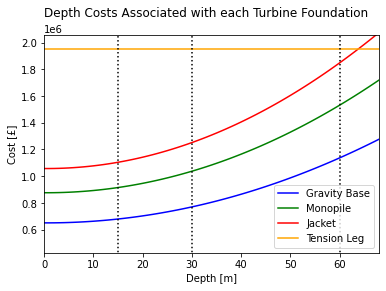

In [411]:
# Plots depth functions for each individual turbine foundation type

Depthx = range(0,math.ceil((max(data['CORR_DEPTH']))),1)
GBCost = [None] * len(Depthx)
MPCost = [None] * len(Depthx)
JCost = [None] * len(Depthx)
TLCost = [None] * len(Depthx)
Depth = 0

for i in Depthx:
    GBCost[i] = foundationDepthCost(GravityBase,Depth)
    MPCost[i] = foundationDepthCost(Monopile,Depth)
    JCost[i] = foundationDepthCost(Jacket,Depth)
    TLCost[i] = TensionLeg
    Depth += 1
    
fig, ax = plt.subplots()
fig.suptitle('Depth Costs Associated with each Turbine Foundation')

x1 = np.linspace(15,15,100)
x2 = np.linspace(30,30,100)
x3 = np.linspace(60,60,100)
y = np.linspace(0,TensionLeg+500000,100)

ax.set_xlabel('Depth [m]') # x axis label
ax.set_ylabel('Cost [£]') # y axis label
ax.set_xlim(0,math.ceil((max(data['CORR_DEPTH']-1)))) #x limits
ax.set_ylim(Monopile-500000,TensionLeg+100000) #y limits
ax.plot(Depthx,GBCost,'blue')
ax.plot(Depthx,MPCost,'green')
ax.plot(Depthx,JCost,'red')
ax.plot(Depthx,TLCost,'orange')
ax.plot(x1,y,':',color='k')
ax.plot(x2,y,':',color='k')
ax.plot(x3,y,':',color='k')
plt.legend(['Gravity Base','Monopile','Jacket','Tension Leg'])

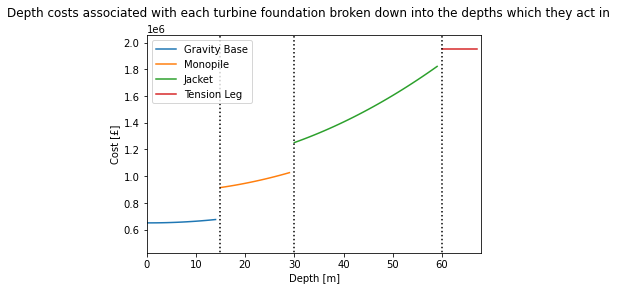

In [412]:
# Plots depth functions for each individual turbine foundation type but only considers the depths for which the foundation will act in

GBCost2 = GBCost[Depthx[0]:Depthx[15]]
MPCost2 = MPCost[Depthx[15]:Depthx[30]]
JCost2 = JCost[Depthx[30]:Depthx[60]]
TLCost2 = TLCost[Depthx[60]:max(Depthx)]

fig, ax = plt.subplots()
fig.suptitle('Depth costs associated with each turbine foundation broken down into the depths which they act in')

ax.set_xlabel('Depth [m]') # x axis label
ax.set_ylabel('Cost [£]') # y axis label
ax.set_xlim(0,math.ceil((max(data['CORR_DEPTH']-1)))) #x limits
ax.set_ylim(Monopile-500000,TensionLeg+100000) #y limits
ax.plot(Depthx[0:15],GBCost2)
ax.plot(Depthx[15:30],MPCost2)
ax.plot(Depthx[30:60],JCost2)
ax.plot(Depthx[60:max(Depthx)],TLCost2)
ax.plot(x1,y,':',color='k')
ax.plot(x2,y,':',color='k')
ax.plot(x3,y,':',color='k')
plt.legend(['Gravity Base','Monopile','Jacket','Tension Leg'])

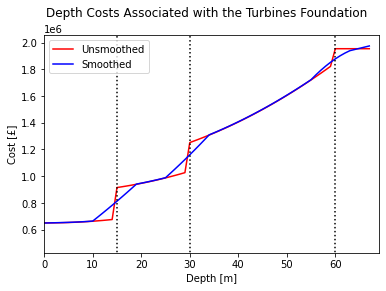

In [413]:
# Combines all the indivdual depths costs over there used depths into one plot and smooths the data

GBMPJTL = GBCost2+MPCost2+JCost2+TLCost2

fig, ax = plt.subplots()
fig.suptitle('Depth Costs Associated with the Turbines Foundation')

ax.set_xlabel('Depth [m]') # x axis label
ax.set_ylabel('Cost [£]') # y axis label
ax.set_xlim(0,math.ceil((max(data['CORR_DEPTH'])))) #x limits
ax.set_ylim(Monopile-500000,TensionLeg+100000) #y limits
ax.plot(Depthx[0:max(Depthx)],GBMPJTL,color='r')
smoothed_2dg = savgol_filter(GBMPJTL, window_length = 9, polyorder = 1)
ax.plot(Depthx[0:max(Depthx)], smoothed_2dg, color='b')
plt.legend(['Unsmoothed','Smoothed'])
ax.plot(x1,y,':',color='k')
ax.plot(x2,y,':',color='k')
ax.plot(x3,y,':',color='k')

In [414]:
def foundations(positionlist):
    
    DepthPerTurbine = [None] * (len(positionlist)-1) # none defines a null/no value. Get a null list the size of the np. turbines
    FoundationCost = [None] * (len(positionlist)-1) # Get a null list the size of the number of turbines
    FoundationCostTotal = 0 # Assigns initial value to variable
    
    for i in range(0,len(positionlist)-1): # loops for amount of turbines
        DepthPerTurbine[i] = spline.SmoothBivariateSpline.ev(smooth, positionlist[i+1,0], positionlist[i+1,1])
        
        FoundationCost[i] = np.interp(DepthPerTurbine[i],Depthx[0:max(Depthx)],smoothed_2dg)

        FoundationCostTotal += FoundationCost[i]
        
    return FoundationCostTotal

FoundationCostTotal = foundations(positionlist)

In [415]:
# Function for calculated payback time, discounted payback time, Net Present Value, and Profitability Index

def Payback(TPO,TotalCost,positionlist):
    
    nturb=np.size(positionlist,0)-1 # -1 due to the substation at positonlist[0,:]
    
    CashFlowYearly = (ElectricityCostperkWh*24*365*(TPO/1000))-(OperatingandMaintenanceCostsperAnnum*nturb) # Calculates the yaerly cash flow for the windfarm
    PayBackTime = TotalCost/CashFlowYearly # calculates payback time in years
    DiscountedPayBackTime = (np.log(1/(1-((TotalCost*DiscountRate)/CashFlowYearly))))/np.log(1+DiscountRate) #Calculates payback time but takes into account the time value of money
    
    l=0
    NPV = 0
    
    for l in range(LifeTimeTurbineOperatingTime):
        l+=1
        NPV = NPV + (CashFlowYearly)/((1+DiscountRate)**l) #NPV is a method used to determine the current value of future cash flows generated by the project
    
    NPV = NPV - TotalCost
    ProfIndex = (NPV+TotalCost)/TotalCost # Probability index >1 it's profitable <1 its not
    
    return PayBackTime,DiscountedPayBackTime,NPV,ProfIndex

In [416]:
#PLOTTING FUNCTION

def plotting_function(positionlist,indiceslist,MSTweight,data,OnshoreSubstation,ExportDistance):
    
    mindepth = depthvalues(positionlist)[1]
    maxdepth = depthvalues(positionlist)[2]
    
    nturb=np.size(positionlist,0)-1 # -1 due to the substation ar positonlist[0,:]
    links = [None] * math.ceil(nturb/maxnodespertree) # math.ceil rounds a number upwards to its nearest integer
    MSTWeightSum = 0

    fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(7,7))
    fig.suptitle('Plot Showing Sea Floor Topography and Turbines with Cables')
    
    #Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
    ax1.set_ylabel('y distance [m]') # y axis label
    ax1.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
    ax1.set_ylim([min(positionlist[:,1])-100, max(positionlist[:,1])+100]) #y limits 
    
    #Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
    ax2.set_xlabel('x distance [m]') # x axis label
    ax2.set_ylabel('y distance [m]') # y axis label
    ax2.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
    ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-1000, min(positionlist[:,1])-100]) #y limits
    
    for a in range(0,len(MSTweight)):
        MSTWeightSum += MSTweight[a][0]
        links[a] = MSTweight[a][1]
        for b in links[a]:
            u = positionlist[(indiceslist[a,b[0]])][0], positionlist[(indiceslist[a,b[1]])][0]
            v = positionlist[(indiceslist[a,b[0]])][1], positionlist[(indiceslist[a,b[1]])][1]
            ax1.plot(u,v, c='black')
    
    FoundationCostTotal = foundations(positionlist)
    ExportCableCost = (ExportDistance*ExportCableCostperMeter) # Export cable cost
    FixedCost = (OffshoreSubstationCostperMW+OnshoreSubstationCostperMW)*TurbineRating*nturb
    CableCost=(MSTWeightSum/1000)*IACableCostperMeter
    DepthCostAll = depthvalues(positionlist)[0]
    TurbineCostTotal =(nturb)*CostperTurbine
    MaintenanceCosts=(nturb)*MaintenanceCostperTurbine 
    LandCost = LandAreaCost(positionlist,ExportDistance)
    TotalCost=TurbineCostTotal+DepthCostAll+MaintenanceCosts+FixedCost+LandCost+CableCost+ExportCableCost+FoundationCostTotal 

    print('\033[1m'+'Maximum turbines per MST:'+'\033[0m', maximumturbinespertree)
    print('\033[1m'+'Number of turbines:'+'\033[0m', nturb)
    print()
    print('\033[1m'+'Inter-Array Cabling Costs: £'+'\033[0m', CableCost)
    print('\033[1m'+'Export Cabling Costs: £'+'\033[0m', ExportCableCost)
    print('\033[1m'+'Depth Cost: £'+'\033[0m', DepthCostAll)
    print('\033[1m'+'Foundations Cost: £'+'\033[0m', FoundationCostTotal)
    print('\033[1m'+'Turbine Cost: £'+'\033[0m', TurbineCostTotal)
    print('\033[1m'+'Land Cost: £'+'\033[0m', LandCost)
    print('\033[1m'+'Maintenance Cost: £'+'\033[0m', MaintenanceCosts)
    print('\033[1m'+'Fixed Cost:'+'\033[0m', FixedCost)
    print()
    print('\033[1m'+'Budget: £'+'\033[0m', budget)
    print('\033[1m'+'Total Cost: £'+'\033[0m', TotalCost)
        
    levels = np.linspace(mindepth-3,maxdepth+3,24) # Change to min(smooth) and max(smooth) somehow
    
    fig.subplots_adjust(left=0.1, right=0.8) #Adjusts plots to be able to fit a single color bar across both plots
    
    #Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
    tcf = ax1.tricontourf(data['centered_easting'], data['centered_northing'], smooth(data['centered_easting'], data['centered_northing'], grid=False), levels=levels, cmap = 'viridis_r')
    cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8]) #Locates colorbar across both subplots
    cbar = plt.colorbar(tcf,cax=cb_ax) #plots colorbar with location as stated by cb_ax
    cbar.set_label('Depth (m)')    
    
    ax1.scatter(positionlist[:,0],positionlist[:,1],c='red') # Prints turbine positions in red
    ax1.scatter(positionlist[0,0],positionlist[0,1],c='blue') # offshore Substation
    ax1.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
    
    #Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
    tcf = ax2.tricontourf(data['centered_easting'], data['centered_northing'], smooth(data['centered_easting'], data['centered_northing'], grid=False), levels=levels, cmap = 'viridis_r')

    ax2.scatter(OnshoreSubstation[0],OnshoreSubstation[1],c='blue') #onshore substation
    ax2.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
    ax2.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
    
    fig, ax3 = plt.subplots()
    PieChartLabels = ['(Inter-Array) Cabling Costs', 'Depth Costs', 'Turbine Costs', 'Land Costs', '(Life time) Maintenance Costs', 'Fixed Costs','(Export) Cabling Costs','Foundation Costs'] # Titles for each segment of pie chart
    sizes = [CableCost,DepthCostAll,TurbineCostTotal,LandCost,MaintenanceCosts,FixedCost,ExportCableCost,FoundationCostTotal] # Figures for each segment of pie chart
    
    ax3.pie(sizes, labels=PieChartLabels, autopct='%1.1f%%') # Pie chart with brekadown of all associated costs
    ax3.axis('equal') #equal aspect ratio
    ax3.set_title('Wind Farm Costs') #Pie chart title
                                                                                                  
    return TotalCost

 C:\Users\adamb\OneDrive - University of Warwick\University Documents\3rd Year\ES327 Individual Project\Wind-Farm-Layout-Gaussian-Optimisation\three_desc_model.py:335: RuntimeWarning:invalid value encountered in arccos
 C:\Users\adamb\anaconda3\lib\site-packages\numpy\lib\function_base.py:2197: RuntimeWarning:invalid value encountered in q (vectorized)


PRE-OPTIMISED LAYOUT INFORMATION
Maximum turbines per MST: 10
Number of turbines: 92

Inter-Array Cabling Costs: £ 7425805.078797222
Export Cabling Costs: £ 10507878.151260504
Depth Cost: £ 14613370.971835075
Foundations Cost: £ 92966356.24567449
Turbine Cost: £ 204293116.21021464
Land Cost: £ 4928227.240737273
Maintenance Cost: £ 120520000.0
Fixed Cost: 29571428.57142857

Budget: £ 500000000.0
Total Cost: £ 484826182.4699478
Total Power Output: 20620399.73695026 W
Theoretical Max Total Power Output: 69358235.07470647 W

 <ipython-input-415-57a7f6411a0e>:9: RuntimeWarning:invalid value encountered in log



Percentage power lost to wake effcts: 70.26971676147782 %
Cost per Watt: 23.511968179800824 £/W

Payback Time: 24.25902179467437 years
Discounted Payback Time: nan years
NPV: £ -273100601.48162395 over a  20 year period
Profitability Index: £ 0.43670409858990605 over a  20 year period


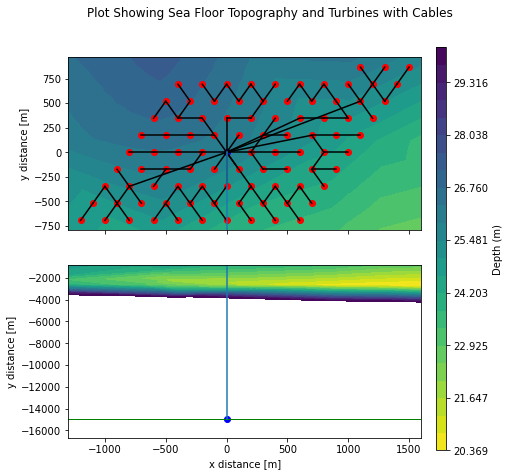

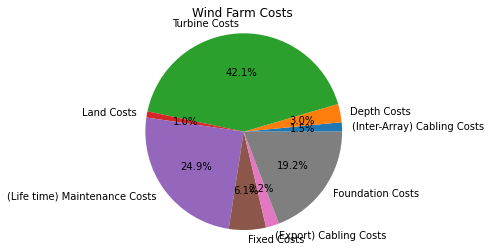

In [417]:
## PRE-OPTIMISED LAYOUT AND GAUSSIAN TESTING

# CALCULATES 
wsr=windspeedreduction(positionlist[1:,:],angles,predict_class)
powout=power(wsr,velocities) # total output power
output=np.tensordot(powout,wsp,axes=2)

## Below calculates max theoreticl power output
wsr_noWake = np.multiply(0.92477772, np.ones(wsr.shape))  ## 0.92477772 is not 1 because of the impact of the hub height
powout_noWake = power(wsr_noWake,velocities)
output_noWake=np.tensordot(powout_noWake,wsp,axes=2)
theoretical_max_power = np.sum(output_noWake)


#DISPLAYING PRE-OPTIMISED LAYOUT AND ASSOCIATED INFO

print('\033[1m'+'\033[4m'+'PRE-OPTIMISED LAYOUT INFORMATION'+'\033[0m'+'\033[0m')
MSTweight = Minimum_Spanning_Tree(distance,indiceslist)
TotalCost = plotting_function(positionlist,indiceslist,MSTweight,data,OnshoreSubstation,ExportDistance)

PayBackTime,DiscountedPayBackTime,NPV,ProfIndex = Payback((np.sum(output)),TotalCost,positionlist)

print('\033[1m'+'Total Power Output:'+'\033[0m', np.sum(output), 'W')
print('\033[1m'+'Theoretical Max Total Power Output:'+'\033[0m', theoretical_max_power, 'W')
print('\033[1m'+'Percentage power lost to wake effcts:'+'\033[0m', (1-(np.sum(output)/theoretical_max_power))*100, '%')
print('\033[1m'+'Cost per Watt:'+'\033[0m',TotalCost/np.sum(output),'£/W')
print('')
print('\033[1m'+'Payback Time:'+'\033[0m',PayBackTime,'years')
print('\033[1m'+'Discounted Payback Time:'+'\033[0m',DiscountedPayBackTime,'years')
print('\033[1m'+'NPV: £'+'\033[0m',NPV,'over a ',LifeTimeTurbineOperatingTime,'year period')
print('\033[1m'+'Profitability Index: £'+'\033[0m',ProfIndex,'over a ',LifeTimeTurbineOperatingTime,'year period')

In [418]:
#REDUCING NO. OF TURBINES PRE-OPTIMISATION

overspend = TotalCost - budget
if overspend > 0:
    nturbstoremove = math.floor(overspend/(MinCostperTurbTot))
    ### It can be safely assumed that this many turbines at minimum can be removed.
    print('Number of removed turbines:', nturbstoremove)
    for amount in range(0,nturbstoremove):
        nturb = nturb - 1
        positionlist = np.delete(positionlist, len(positionlist)-1, 0)
    indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree)
    print('new number of turbines:', nturb)

In [419]:
v=2
for amount in range(0,v):
    nturb = nturb - 1
    positionlist = np.delete(positionlist, len(positionlist)-1, 0)
indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree)

 C:\Users\adamb\anaconda3\lib\site-packages\pulp\pulp.py:1352: UserWarning:Spaces are not permitted in the name. Converted to '_'


In [420]:
#TARGET FUNCTION

# analyses the coordinates to collate the distances and angles between all of them
# calculates the minimum spanning tree length and adds the assumption of cabling costs,
# turbines costs, maintenance costs and fixed costs.

smallestindiceslist = []
smallestTotalCost = None
smallestCostPerWatt = 10000000000000.0
smallestpositionlist = []
smallestExportDistance = None

def targetfunction(coord_flat):
    
    #Global variables are used instead of res.x as res.x only holds the coordinates, not the other associated parameters,
    #inc. the optimal clustering, which will not necessarily be the same if the clustering algorithm is run again as the
    #start position is random for clustering. Additionally, res.x only provides an approximate minimization, whereas
    #storing values as global variables and finding the minimum guarantees that the minimum value found is returned.
    
    global smallestindiceslist
    global smallestTotalCost
    global smallestCostPerWatt
    global smallestpositionlist
    global smallestExportDistance

    arr2=np.reshape(coord_flat,(-1,2)) # undoes the coordinate flattening
    hull = ConvexHull(arr2)
    arr1 = np.array([np.mean(hull.points[hull.vertices,0]),np.mean(hull.points[hull.vertices,1])])
    arr1 = np.reshape(arr1,(-1,2))
    positionlist = np.concatenate((arr1,arr2),axis=0)
    #positionlist = np.reshape(coord_flat,(-1,2))#np.concatenate((arr1,arr2),axis=0) #np.reshape(coord_flat,(-1,2))
    
    nturb=np.size(positionlist,0)-1 # determines number of turbines (-1 due to the substation)
    print('nturb', nturb)
    
    OnshoreSubstation,ExportDistance = Substation_To_Shore_Connection(positionlist)

    indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree) # calls clustering function
    distance,angle,distance_global,angle_global = geom_analysis(positionlist,indiceslist) # calls pre-MST function
    
    MSTweight=Minimum_Spanning_Tree(distance,indiceslist) # Calls MST function
    MSTWeightSum=0
    
    for a in range(0,math.ceil(nturb/maxnodespertree)): 
        MSTWeightSum += MSTweight[a][0] 
#     wsr=windspeedreduction(distance_global,angle_global,angles,model) ## old WSR function
    wsr=windspeedreduction(positionlist[1:,:],angles,predict_class) ## new WSR function ## the "turbine" at origin is substantion and hence removed
    powout=power(wsr,velocities) # total output power
    output=np.tensordot(powout,wsp,axes=2) # reduced power output due to wake effects
    
    FoundationCostTotal = foundations(positionlist)
    ExportCableCost = (ExportDistance*ExportCableCostperMeter) # Export cable cost
    FixedCost = (OffshoreSubstationCostperMW+OnshoreSubstationCostperMW)*TurbineRating*nturb
    CableCost= (MSTWeightSum/1000)*IACableCostperMeter
    DepthCostAll = depthvalues(positionlist)[0]
    TurbineCostTotal= (nturb)*CostperTurbine
    MaintenanceCosts= (nturb)*MaintenanceCostperTurbine
    LandCost = LandAreaCost(positionlist,ExportDistance)
    TotalCost= TurbineCostTotal+DepthCostAll+MaintenanceCosts+FixedCost+LandCost+CableCost+ExportCableCost+FoundationCostTotal

    print('Total power output in Watts', np.sum(output),'Total Cost in £', TotalCost, '£/W', (TotalCost/(np.sum(output))))###

    CostperWatt = TotalCost/(np.sum(output))
    
    if CostperWatt < smallestCostPerWatt:
        smallestCostPerWatt = CostperWatt
        smallestindiceslist = indiceslist
        smallestTotalCost = TotalCost
        smallestpositionlist = positionlist
        smallestExportDistance = ExportDistance

    print('smallest cost per watt',smallestCostPerWatt)
    
    return CostperWatt

In [421]:
angles

array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
        55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.,
       110., 115., 120., 125., 130., 135., 140., 145., 150., 155., 160.,
       165., 170., 175., 180., 185., 190., 195., 200., 205., 210., 215.,
       220., 225., 230., 235., 240., 245., 250., 255., 260., 265., 270.,
       275., 280., 285., 290., 295., 300., 305., 310., 315., 320., 325.,
       330., 335., 340., 345., 350., 355.])

In [422]:
# OPTIMIZATION

#xright = 0
#xleft = 0
#yup = 0
#ydown = 0
#for xright in range(0,nturb+1):
 #   if positionlist[xright,0]>0:
  #      positionlist[xright,0] = positionlist[xright,0] + 250
#for xleft in range(0,nturb+1):
 #   if positionlist[xleft,0]<0:
  #      positionlist[xleft,0] = positionlist[xleft,0] - 250
#for yup in range(0,nturb+1):
 #   if positionlist[yup,1]>0:
  #      positionlist[yup,1] = positionlist[yup,1] + 250
#for ydown in range(0,nturb+1):
 #   if positionlist[ydown,1]<0:
  #      positionlist[ydown,1] = positionlist[ydown,1] - 250
        
        
t1_start = perf_counter() # timer starts

dvel=1.5
dang=5
velocities=np.arange(Vc,Vf,dvel)
angles=np.arange(0,360,dang)        
wsp=windspeedprobability(angles,velocities,dang,dvel) # tells probability of getting wind from a certain direction with a certain velocity.

while True:  
    
    iteration_time_start = perf_counter()
    
    #flat_coords=positionlist.flatten() # turns 2D coords into single list of data without any more structure.
    flat_coords=positionlist[1:,:].flatten() # turns 2D coords into single list of data without any more structure.
        
    # b = (Lower bound, Upper bound)
    b2 = ((min(positionlist[:,0]))-1000,(max(positionlist[:,0]))+1000) #bounds for x coordinates
    #b3 = ((OnshoreSubstation[1]+((TooCloseShore-2500))),(max(positionlist[:,1]))+1000) #bounds for y coordinates of turbines
    b3 = (((min(positionlist[:,1]))-1000),(max(positionlist[:,1]))+1000) #bounds for y coordinates of turbines
    bnd = (b2,b3) #bounds for x,y coordinates of each turbine 
    bnd1 = (bnd*(nturb)) #repeats bnd for the amount of turbines 
    bnds = bnd1 #Combines all bounds into a list for use in the optimization function
    
    #res = minimize(targetfunction, flat_coords, method='L-BFGS-B', jac=False, bounds=bnds, options={'disp': 2, 'eps': 50, 'ftol': 1e-17, 'gtol': 1e-17})
    res = minimize(targetfunction, flat_coords, method='L-BFGS-B', jac=False, options={'disp': 2, 'eps': 50})#, 'ftol': 1e-17, 'gtol': 1e-17})

    #res = minimize(targetfunction, flat_coords, method='Nelder-Mead', jac=False, bounds=bnds, options={'disp': 2, 'xatol': 1e-3, 'fatol': 1e-3})#, 'ftol': 1e-17, 'gtol': 1e-17})
    #res = minimize(targetfunction, flat_coords, method='TNC', jac=False, bounds=bnds, options={'disp': 2, 'eps':50})#, 'ftol': 1e-17, 'gtol': 1e-17})
    
    iteration_time_end = perf_counter()
    print(iteration_time_end-iteration_time_start)
    
    if smallestTotalCost<=budget: #if under budget
        if not res.success:
            print(res.status, res.message) 
        else:
            break # Stops optimization when minimization is under budget after an iteration of 'minimize' 
    else: # over budget then removes a turbine and resets approrate varaibles 
        nturb = nturb - 1 
        smallestindiceslist = []
        smallestTotalCost = None
        smallestCostPerWatt = 10000000000000.0
        smallestpositionlist = []
        smallestExportDistance = None
        
        wsr=windspeedreduction(positionlist[1:,:],angles,predict_class) ## new WSR function ## the "turbine" at origin is substantion and hence removed
        powout=power(wsr,velocities) # total output power
        outputs=np.tensordot(powout,wsp,axes=2)
        LowestPower = min(outputs)
        LowestPowerIndex = np.argmin(outputs)
        LowestPowerTurbine = positionlist[LowestPowerIndex+1,:]
        positionlist = np.delete(positionlist, LowestPowerIndex+1, 0) 

        # CANNOT USE CALLBACK as this only returns targetfunction output and not the other variables that are needed too.
          
t1_stop = perf_counter() # timer ends
totaltime = t1_stop - t1_start # total run time in seconds
print('Total function time:', totaltime)

nturb 90


 C:\Users\adamb\OneDrive - University of Warwick\University Documents\3rd Year\ES327 Individual Project\Wind-Farm-Layout-Gaussian-Optimisation\three_desc_model.py:335: RuntimeWarning:invalid value encountered in arccos
 C:\Users\adamb\anaconda3\lib\site-packages\numpy\lib\function_base.py:2197: RuntimeWarning:invalid value encountered in q (vectorized)


Total power output in Watts 20225856.386987597 Total Cost in £ 474073761.43200433 £/W 23.438995727122933
smallest cost per watt 23.438995727122933
nturb 90
Total power output in Watts 20242371.59366579 Total Cost in £ 474163314.4676373 £/W 23.42429651948548
smallest cost per watt 23.42429651948548
nturb 90
Total power output in Watts 20240521.778105214 Total Cost in £ 474262199.08078873 £/W 23.43132278308223
smallest cost per watt 23.42429651948548
nturb 90
Total power output in Watts 20246662.207460646 Total Cost in £ 474266603.3844713 £/W 23.424434038797266
smallest cost per watt 23.42429651948548
nturb 90
Total power output in Watts 20244495.333996385 Total Cost in £ 474124091.81955004 £/W 23.41990175587919
smallest cost per watt 23.41990175587919
nturb 90
Total power output in Watts 20245337.65828424 Total Cost in £ 474273274.2704944 £/W 23.42629608236864
smallest cost per watt 23.41990175587919
nturb 90
Total power output in Watts 20246737.16387316 Total Cost in £ 474371745.913034

Total power output in Watts 20259142.84801882 Total Cost in £ 474157611.40452754 £/W 23.404623530303816
smallest cost per watt 23.383151692963605
nturb 90
Total power output in Watts 20247025.082335122 Total Cost in £ 474269101.1096159 £/W 23.424137579767233
smallest cost per watt 23.383151692963605
nturb 90
Total power output in Watts 20255930.598151293 Total Cost in £ 474086717.29760635 £/W 23.4048351913723
smallest cost per watt 23.383151692963605
nturb 90
Total power output in Watts 20248334.972790033 Total Cost in £ 474272552.40130204 £/W 23.422792690788427
smallest cost per watt 23.383151692963605
nturb 90
Total power output in Watts 20267541.32009813 Total Cost in £ 474317285.4513591 £/W 23.402803426432715
smallest cost per watt 23.383151692963605
nturb 90
Total power output in Watts 20256640.485919103 Total Cost in £ 474160811.2991252 £/W 23.407672739649314
smallest cost per watt 23.383151692963605
nturb 90
Total power output in Watts 20269665.124414217 Total Cost in £ 47423961

Total power output in Watts 20244046.15669172 Total Cost in £ 474206394.29339397 £/W 23.42448691447208
smallest cost per watt 23.383043392026472
nturb 90
Total power output in Watts 20256429.615887184 Total Cost in £ 474111937.57053274 £/W 23.405503662831343
smallest cost per watt 23.383043392026472
nturb 90
Total power output in Watts 20247786.521086935 Total Cost in £ 474181943.05489206 £/W 23.41895211909006
smallest cost per watt 23.383043392026472
nturb 90
Total power output in Watts 20231032.56211414 Total Cost in £ 474328830.47351617 £/W 23.44560659557106
smallest cost per watt 23.383043392026472
nturb 90
Total power output in Watts 20232872.43183395 Total Cost in £ 474265604.0402802 £/W 23.440349640819232
smallest cost per watt 23.383043392026472
nturb 90
Total power output in Watts 20241991.280101527 Total Cost in £ 474150951.5888311 £/W 23.424125869223918
smallest cost per watt 23.383043392026472
nturb 90
Total power output in Watts 20246492.245575476 Total Cost in £ 474247896

Total power output in Watts 20216312.519652445 Total Cost in £ 474330884.81010675 £/W 23.46277959192636
smallest cost per watt 23.380238623302965
nturb 90
Total power output in Watts 20280195.43917738 Total Cost in £ 474332296.9178878 £/W 23.388941114520545
smallest cost per watt 23.380238623302965
nturb 90
Total power output in Watts 20196536.004408434 Total Cost in £ 474085742.110896 £/W 23.473616565108696
smallest cost per watt 23.380238623302965
nturb 90
Total power output in Watts 20225623.33458994 Total Cost in £ 474212334.5302883 £/W 23.446117169565227
smallest cost per watt 23.380238623302965
nturb 90
Total power output in Watts 20230798.32972348 Total Cost in £ 474083777.4170486 £/W 23.433765177744643
smallest cost per watt 23.380238623302965
nturb 90
Total power output in Watts 20262855.295607723 Total Cost in £ 474145296.09777313 £/W 23.3997276879607
smallest cost per watt 23.380238623302965
nturb 90
Total power output in Watts 20269884.97671972 Total Cost in £ 474046583.152

Total power output in Watts 21668362.9972066 Total Cost in £ 474166844.76362556 £/W 21.88291034374647
smallest cost per watt 21.862857848129426
nturb 90
Total power output in Watts 21660581.66482069 Total Cost in £ 474077590.7891853 £/W 21.886650973881398
smallest cost per watt 21.862857848129426
nturb 90
Total power output in Watts 21668441.480705094 Total Cost in £ 474132113.03147894 £/W 21.881228211714035
smallest cost per watt 21.862857848129426
nturb 90
Total power output in Watts 21665057.070616573 Total Cost in £ 474173557.60843813 £/W 21.886559359750787
smallest cost per watt 21.862857848129426
nturb 90
Total power output in Watts 21674202.151496574 Total Cost in £ 474205016.81412333 £/W 21.878776136697613
smallest cost per watt 21.862857848129426
nturb 90
Total power output in Watts 21672954.472503215 Total Cost in £ 474204514.59161353 £/W 21.880012491755267
smallest cost per watt 21.862857848129426
nturb 90
Total power output in Watts 21667589.94821541 Total Cost in £ 4741045

Total power output in Watts 21657789.59758217 Total Cost in £ 474254676.32129955 £/W 21.89764907376533
smallest cost per watt 21.862857848129426
nturb 90
Total power output in Watts 21667479.34726551 Total Cost in £ 474254265.55181456 £/W 21.887837433737605
smallest cost per watt 21.862857848129426
nturb 90
Total power output in Watts 21650824.020530738 Total Cost in £ 474292647.36647516 £/W 21.9064478523644
smallest cost per watt 21.862857848129426
nturb 90
Total power output in Watts 21665620.66559589 Total Cost in £ 474241160.50331366 £/W 21.889110301667426
smallest cost per watt 21.862857848129426
nturb 90
Total power output in Watts 21650384.291238617 Total Cost in £ 474170149.3535461 £/W 21.901234776023408
smallest cost per watt 21.862857848129426
nturb 90
Total power output in Watts 21665456.332181375 Total Cost in £ 474282567.5940826 £/W 21.891187534766765
smallest cost per watt 21.862857848129426
nturb 90
Total power output in Watts 21647649.96241471 Total Cost in £ 474145300.

Total power output in Watts 21617186.10925848 Total Cost in £ 474256284.22687995 £/W 21.93885373562841
smallest cost per watt 21.85807148313693
nturb 90
Total power output in Watts 21621474.11663765 Total Cost in £ 474442991.27768266 £/W 21.943138044995756
smallest cost per watt 21.85807148313693
nturb 90
Total power output in Watts 21601223.703911245 Total Cost in £ 474318354.02385163 £/W 21.957939074440898
smallest cost per watt 21.85807148313693
nturb 90
Total power output in Watts 21602729.08134816 Total Cost in £ 474125328.22281927 £/W 21.94747369359828
smallest cost per watt 21.85807148313693
nturb 90
Total power output in Watts 21592890.62353645 Total Cost in £ 474118156.1563785 £/W 21.9571415621207
smallest cost per watt 21.85807148313693
nturb 90
Total power output in Watts 21577802.61420013 Total Cost in £ 474275985.94397795 £/W 21.97980927084122
smallest cost per watt 21.85807148313693
nturb 90
Total power output in Watts 21608813.83894461 Total Cost in £ 474167630.3535912 £

Total power output in Watts 21681206.81084976 Total Cost in £ 474155799.523904 £/W 21.869437603751184
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21684017.23237211 Total Cost in £ 474269610.972771 £/W 21.871851783291014
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21682045.159788106 Total Cost in £ 474263415.94405866 £/W 21.873555397976745
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21676229.98180151 Total Cost in £ 474124440.71574247 £/W 21.873012101910632
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21686142.052110635 Total Cost in £ 474099316.72263193 £/W 21.861856091479837
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21675110.36960012 Total Cost in £ 474106415.1216627 £/W 21.87331031017995
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21681062.287143458 Total Cost in £ 474218635.5

Total power output in Watts 21665995.515134968 Total Cost in £ 474158023.0497826 £/W 21.884894359853227
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21666413.107212123 Total Cost in £ 474192322.50613683 £/W 21.886055627190636
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21669348.412049938 Total Cost in £ 474234248.0059777 £/W 21.885025751040327
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21655484.731421888 Total Cost in £ 474164216.9595679 £/W 21.89580251101747
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21647740.43913864 Total Cost in £ 474220733.75094485 £/W 21.906246293195764
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21656484.23432037 Total Cost in £ 474349069.21054316 £/W 21.90332761671504
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21651696.810921524 Total Cost in £ 47409071

Total power output in Watts 21665533.33053582 Total Cost in £ 474230898.435719 £/W 21.888724879314594
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21656914.975482523 Total Cost in £ 474234812.4043905 £/W 21.89761620901522
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21665338.379653618 Total Cost in £ 474288463.6621555 £/W 21.89157885978693
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21643309.494820867 Total Cost in £ 474194058.1147119 £/W 21.9094985555783
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21658398.374955397 Total Cost in £ 474398123.61278945 £/W 21.903656743213194
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21615841.728983935 Total Cost in £ 474213911.1398319 £/W 21.93825792608274
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21700819.12966356 Total Cost in £ 474396743.3903

Total power output in Watts 21663850.597585045 Total Cost in £ 474225223.51432496 £/W 21.89016312581055
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21661759.744877517 Total Cost in £ 474196566.0145922 £/W 21.89095307119396
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21670616.00569003 Total Cost in £ 474348244.0779033 £/W 21.88900601410473
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21703501.683595374 Total Cost in £ 474234093.193153 £/W 21.850579694778176
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21700054.00368457 Total Cost in £ 474158831.05961806 £/W 21.85058299758646
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21671602.218323104 Total Cost in £ 474658101.98863614 £/W 21.902307785407665
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21683371.210469328 Total Cost in £ 474190713.4

Total power output in Watts 21682867.40679287 Total Cost in £ 474222530.6813355 £/W 21.87084031758501
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21686756.518301312 Total Cost in £ 474283206.05175364 £/W 21.869716001630266
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21671331.21644596 Total Cost in £ 474268772.95403254 £/W 21.884616510965373
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21691930.12508619 Total Cost in £ 474316610.8696035 £/W 21.86603995746178
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21683841.333247982 Total Cost in £ 474343568.53250617 £/W 21.875439929787344
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21689298.14359986 Total Cost in £ 474153730.124233 £/W 21.861183657717742
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21677748.818549626 Total Cost in £ 474168186.5

Total power output in Watts 21674061.537486233 Total Cost in £ 474207992.0562066 £/W 21.879055350841522
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21666447.528458066 Total Cost in £ 474259068.29378694 £/W 21.88910146302782
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21672301.77172542 Total Cost in £ 474308795.51403636 £/W 21.88548316233023
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21663068.23574178 Total Cost in £ 474152429.1968129 £/W 21.887593393373123
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21673747.269776575 Total Cost in £ 474259909.14498085 £/W 21.881767986024403
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21661382.31665509 Total Cost in £ 474166424.13310933 £/W 21.889942996321633
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21677199.012379073 Total Cost in £ 47428511

Total power output in Watts 21630765.6413699 Total Cost in £ 474046844.1663133 £/W 21.91539828158812
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21640212.693542104 Total Cost in £ 474244317.6500792 £/W 21.914956399278076
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21630793.510282133 Total Cost in £ 474213574.3031701 £/W 21.923078045091323
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21641096.04009738 Total Cost in £ 474272002.8848812 £/W 21.915341164150533
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21630362.817718614 Total Cost in £ 474199989.2785584 £/W 21.92288651256997
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21648732.602153074 Total Cost in £ 474199852.13360965 £/W 21.904277762960042
smallest cost per watt 21.849203380726674
nturb 90
Total power output in Watts 21622751.213404026 Total Cost in £ 474225041.4

Total power output in Watts 21714663.18781698 Total Cost in £ 474272510.23295796 £/W 21.841117503450327
smallest cost per watt 21.829314215264493
nturb 90
Total power output in Watts 21710121.22165075 Total Cost in £ 474281969.34595793 £/W 21.846122575905888
smallest cost per watt 21.829314215264493
nturb 90
Total power output in Watts 21718630.499925483 Total Cost in £ 474224615.0958626 £/W 21.834922560954737
smallest cost per watt 21.829314215264493
nturb 90
Total power output in Watts 21713553.86827176 Total Cost in £ 474260675.3973007 £/W 21.841688296373217
smallest cost per watt 21.829314215264493
nturb 90
Total power output in Watts 21702751.367321346 Total Cost in £ 474188203.66163397 £/W 21.849220664972325
smallest cost per watt 21.829314215264493
nturb 90
Total power output in Watts 21703422.77493258 Total Cost in £ 474096039.2765745 £/W 21.844298210149358
smallest cost per watt 21.829314215264493
nturb 90
Total power output in Watts 21701258.218733665 Total Cost in £ 47419247

Total power output in Watts 21692961.265314534 Total Cost in £ 474246205.1208138 £/W 21.861755032914704
smallest cost per watt 21.829314215264493
nturb 90
Total power output in Watts 21678952.478790186 Total Cost in £ 474301772.62340605 £/W 21.87844514569806
smallest cost per watt 21.829314215264493
nturb 90
Total power output in Watts 21656061.256742574 Total Cost in £ 474219692.8127053 £/W 21.897781281213263
smallest cost per watt 21.829314215264493
nturb 90
Total power output in Watts 21664970.659121823 Total Cost in £ 474264737.6510096 £/W 21.890855294157767
smallest cost per watt 21.829314215264493
nturb 90
Total power output in Watts 21677257.797385722 Total Cost in £ 474301603.843384 £/W 21.880147769455636
smallest cost per watt 21.829314215264493
nturb 90
Total power output in Watts 21692664.071552575 Total Cost in £ 474190047.3881723 £/W 21.85946575414026
smallest cost per watt 21.829314215264493
nturb 90
Total power output in Watts 21693416.614938088 Total Cost in £ 474166003

Total power output in Watts 21676601.899700265 Total Cost in £ 474385015.57267857 £/W 21.88465783371877
smallest cost per watt 21.829246569339418
nturb 90
Total power output in Watts 21682743.093910202 Total Cost in £ 474220504.9404627 £/W 21.870872282467428
smallest cost per watt 21.829246569339418
nturb 90
Total power output in Watts 21675623.26586835 Total Cost in £ 474396709.8391155 £/W 21.886185417612747
smallest cost per watt 21.829246569339418
nturb 90
Total power output in Watts 21687302.785878677 Total Cost in £ 474216969.0850846 £/W 21.866110957507498
smallest cost per watt 21.829246569339418
nturb 90
Total power output in Watts 21680669.073196616 Total Cost in £ 474450940.26709765 £/W 21.883593106157964
smallest cost per watt 21.829246569339418
nturb 90
Total power output in Watts 21668467.65762304 Total Cost in £ 474185865.3984808 £/W 21.883682450044432
smallest cost per watt 21.829246569339418
nturb 90
Total power output in Watts 21661310.832355775 Total Cost in £ 47430036

Total power output in Watts 21800928.30569337 Total Cost in £ 474350630.13552177 £/W 21.758276688229092
smallest cost per watt 21.752025642331173
nturb 90
Total power output in Watts 21809109.116262 Total Cost in £ 474250695.85062253 £/W 21.74553271857385
smallest cost per watt 21.74553271857385
nturb 90
Total power output in Watts 21803008.379822697 Total Cost in £ 474321521.26535815 £/W 21.754865796607806
smallest cost per watt 21.74553271857385
nturb 90
Total power output in Watts 21808955.414850675 Total Cost in £ 474341075.2023185 £/W 21.74983011241881
smallest cost per watt 21.74553271857385
nturb 90
Total power output in Watts 21806652.285346974 Total Cost in £ 474360467.47888595 £/W 21.753016523202575
smallest cost per watt 21.74553271857385
nturb 90
Total power output in Watts 21814025.617116 Total Cost in £ 474304877.9403396 £/W 21.743115473752102
smallest cost per watt 21.743115473752102
nturb 90
Total power output in Watts 21810781.680423666 Total Cost in £ 474381895.328312

Total power output in Watts 21787281.411418974 Total Cost in £ 474282134.85846245 £/W 21.768761595463925
smallest cost per watt 21.74109686275853
nturb 90
Total power output in Watts 21785776.321994185 Total Cost in £ 474311457.6242201 £/W 21.771611468597115
smallest cost per watt 21.74109686275853
nturb 90
Total power output in Watts 21788409.151693936 Total Cost in £ 474294426.47213113 £/W 21.76819900755614
smallest cost per watt 21.74109686275853
nturb 90
Total power output in Watts 21792732.152121954 Total Cost in £ 474305594.73715174 £/W 21.764393350329353
smallest cost per watt 21.74109686275853
nturb 90
Total power output in Watts 21784890.558967616 Total Cost in £ 474217666.0122354 £/W 21.76819134016841
smallest cost per watt 21.74109686275853
nturb 90
Total power output in Watts 21791483.584167667 Total Cost in £ 474301933.9686953 £/W 21.765472375331687
smallest cost per watt 21.74109686275853
nturb 90
Total power output in Watts 21786468.13372056 Total Cost in £ 474333484.716

Total power output in Watts 21785421.44832367 Total Cost in £ 474314949.20699495 £/W 21.77212638883753
smallest cost per watt 21.738116326357932
nturb 90
Total power output in Watts 21784055.16635309 Total Cost in £ 474326628.6768881 £/W 21.774028070288622
smallest cost per watt 21.738116326357932
nturb 90
Total power output in Watts 21787575.42289993 Total Cost in £ 474411456.2220578 £/W 21.774403393386557
smallest cost per watt 21.738116326357932
nturb 90
Total power output in Watts 21783709.45844393 Total Cost in £ 474418178.9738014 £/W 21.778576320017187
smallest cost per watt 21.738116326357932
nturb 90
Total power output in Watts 21787837.756435525 Total Cost in £ 474327701.0255971 £/W 21.77029709547446
smallest cost per watt 21.738116326357932
nturb 90
Total power output in Watts 21784391.315170556 Total Cost in £ 474276434.356937 £/W 21.77138793988946
smallest cost per watt 21.738116326357932
nturb 90
Total power output in Watts 21789712.23741224 Total Cost in £ 474407249.61287

Total power output in Watts 21786872.259762045 Total Cost in £ 474419332.53819567 £/W 21.775467670703517
smallest cost per watt 21.738116326357932
nturb 90
Total power output in Watts 21777235.85292549 Total Cost in £ 474271143.12719506 £/W 21.778298509977464
smallest cost per watt 21.738116326357932
nturb 90
Total power output in Watts 21787054.622199833 Total Cost in £ 474376799.6913769 £/W 21.773333197963
smallest cost per watt 21.738116326357932
nturb 90
Total power output in Watts 21786839.691093348 Total Cost in £ 474410240.0963862 £/W 21.77508288594648
smallest cost per watt 21.738116326357932
nturb 90
Total power output in Watts 21786591.737884067 Total Cost in £ 474330576.64652014 £/W 21.77167417250127
smallest cost per watt 21.738116326357932
nturb 90
Total power output in Watts 21780428.80358192 Total Cost in £ 474274534.6864953 £/W 21.7752615875266
smallest cost per watt 21.738116326357932
nturb 90
Total power output in Watts 21796772.79099719 Total Cost in £ 474398086.8974

Total power output in Watts 23337366.370856974 Total Cost in £ 476472210.18298006 £/W 20.41670866417835
smallest cost per watt 20.37606799577521
nturb 90
Total power output in Watts 23350819.552043002 Total Cost in £ 476527121.7452286 £/W 20.40729751189981
smallest cost per watt 20.37606799577521
nturb 90
Total power output in Watts 23363045.33815466 Total Cost in £ 476514018.88145983 £/W 20.396057619391563
smallest cost per watt 20.37606799577521
nturb 90
Total power output in Watts 23352943.709605057 Total Cost in £ 476467451.2139961 £/W 20.402886126001547
smallest cost per watt 20.37606799577521
nturb 90
Total power output in Watts 23302587.613546018 Total Cost in £ 476568052.83619225 £/W 20.45129325290719
smallest cost per watt 20.37606799577521
nturb 90
Total power output in Watts 23351438.299619466 Total Cost in £ 476312346.46596134 £/W 20.3975592575693
smallest cost per watt 20.37606799577521
nturb 90
Total power output in Watts 23343373.09618621 Total Cost in £ 476340032.570103

Total power output in Watts 23326871.216422535 Total Cost in £ 476666677.84714603 £/W 20.434231124470912
smallest cost per watt 20.37606799577521
nturb 90
Total power output in Watts 23335623.25111134 Total Cost in £ 476635786.0718873 £/W 20.425243454733437
smallest cost per watt 20.37606799577521
nturb 90
Total power output in Watts 23324952.08123467 Total Cost in £ 476356406.537005 £/W 20.422610296389077
smallest cost per watt 20.37606799577521
nturb 90
Total power output in Watts 23332258.347425424 Total Cost in £ 476391993.0870207 £/W 20.417740365865086
smallest cost per watt 20.37606799577521
nturb 90
Total power output in Watts 23341193.5479989 Total Cost in £ 476504120.5453528 £/W 20.41472813142431
smallest cost per watt 20.37606799577521
nturb 90
Total power output in Watts 23349992.67493848 Total Cost in £ 476511095.12662816 £/W 20.407333816342774
smallest cost per watt 20.37606799577521
nturb 90
Total power output in Watts 23349412.007357292 Total Cost in £ 476648451.14107144

Total power output in Watts 23298943.327018768 Total Cost in £ 476546394.4746754 £/W 20.45356254084044
smallest cost per watt 20.34975489778293
nturb 90
Total power output in Watts 23327453.413208526 Total Cost in £ 476389506.7472748 £/W 20.421839379927018
smallest cost per watt 20.34975489778293
nturb 90
Total power output in Watts 23375263.027354553 Total Cost in £ 476274322.3787176 £/W 20.375142808932875
smallest cost per watt 20.34975489778293
nturb 90
Total power output in Watts 23391249.40228854 Total Cost in £ 476561456.0929172 £/W 20.373493005734513
smallest cost per watt 20.34975489778293
nturb 90
Total power output in Watts 23384853.905088574 Total Cost in £ 476353233.60910714 £/W 20.37016076912296
smallest cost per watt 20.34975489778293
nturb 90
Total power output in Watts 23248636.231155347 Total Cost in £ 476442793.2981472 £/W 20.493365226286663
smallest cost per watt 20.34975489778293
nturb 90
Total power output in Watts 23353189.179485783 Total Cost in £ 476721953.53259

Total power output in Watts 25657199.618406743 Total Cost in £ 480075148.87290317 £/W 18.71112810489623
smallest cost per watt 18.659858696881784
nturb 90
Total power output in Watts 25672771.19972045 Total Cost in £ 479770520.510301 £/W 18.687913228297116
smallest cost per watt 18.659858696881784
nturb 90
Total power output in Watts 25677028.794912655 Total Cost in £ 480034325.9078053 £/W 18.69508850661544
smallest cost per watt 18.659858696881784
nturb 90
Total power output in Watts 25700073.04943373 Total Cost in £ 480103735.835302 £/W 18.681026116611775
smallest cost per watt 18.659858696881784
nturb 90
Total power output in Watts 25686061.586338434 Total Cost in £ 479956708.9579161 £/W 18.685492415590453
smallest cost per watt 18.659858696881784
nturb 90
Total power output in Watts 25672788.23359944 Total Cost in £ 479717415.5312507 £/W 18.685832297070764
smallest cost per watt 18.659858696881784
nturb 90
Total power output in Watts 25648806.045323037 Total Cost in £ 480112418.671

Total power output in Watts 25642092.954879332 Total Cost in £ 480109795.19142574 £/W 18.723502642168977
smallest cost per watt 18.653127746867792
nturb 90
Total power output in Watts 25666977.27151536 Total Cost in £ 480113175.5569586 £/W 18.705481774426847
smallest cost per watt 18.653127746867792
nturb 90
Total power output in Watts 25653890.182589937 Total Cost in £ 480008441.27625024 £/W 18.71094161001784
smallest cost per watt 18.653127746867792
nturb 90
Total power output in Watts 25646549.360358395 Total Cost in £ 480060860.8026142 £/W 18.718341171644685
smallest cost per watt 18.653127746867792
nturb 90
Total power output in Watts 25653342.760496993 Total Cost in £ 480110233.5646404 £/W 18.715308879899712
smallest cost per watt 18.653127746867792
nturb 90
Total power output in Watts 25620814.785644494 Total Cost in £ 480173212.47526443 £/W 18.7415277965441
smallest cost per watt 18.653127746867792
nturb 90
Total power output in Watts 25537743.090499595 Total Cost in £ 47989711

Total power output in Watts 25692032.122169215 Total Cost in £ 480111115.9370694 £/W 18.687160036780032
smallest cost per watt 18.653127746867792
nturb 90
Total power output in Watts 25631568.12182593 Total Cost in £ 480073209.0119652 £/W 18.729763498284395
smallest cost per watt 18.653127746867792
nturb 90
Total power output in Watts 25671545.83306385 Total Cost in £ 480092500.8986741 £/W 18.701347555016945
smallest cost per watt 18.653127746867792
nturb 90
Total power output in Watts 25656924.128622334 Total Cost in £ 479898924.02166635 £/W 18.704460504145196
smallest cost per watt 18.653127746867792
nturb 90
Total power output in Watts 25672181.8797965 Total Cost in £ 479948976.4606124 £/W 18.69529355579717
smallest cost per watt 18.653127746867792
nturb 90
Total power output in Watts 25523749.487912327 Total Cost in £ 479961749.8538687 £/W 18.804515773874506
smallest cost per watt 18.653127746867792
nturb 90
Total power output in Watts 25660796.88066328 Total Cost in £ 479804043.41

Total power output in Watts 27904272.51589193 Total Cost in £ 485522187.3466281 £/W 17.399564424054255
smallest cost per watt 17.368985581915265
nturb 90
Total power output in Watts 27901569.114291806 Total Cost in £ 485807100.5893359 £/W 17.41146164931974
smallest cost per watt 17.368985581915265
nturb 90
Total power output in Watts 27904018.03759575 Total Cost in £ 485524401.61299425 £/W 17.399802457081115
smallest cost per watt 17.368985581915265
nturb 90
Total power output in Watts 27894814.911358 Total Cost in £ 485643173.340625 £/W 17.409800885356816
smallest cost per watt 17.368985581915265
nturb 90
Total power output in Watts 27899341.533370513 Total Cost in £ 485493966.80469674 £/W 17.401628143230386
smallest cost per watt 17.368985581915265
nturb 90
Total power output in Watts 27886242.572695896 Total Cost in £ 485593695.79392964 £/W 17.41337846172888
smallest cost per watt 17.368985581915265
nturb 90
Total power output in Watts 27914653.08313841 Total Cost in £ 485343571.221

Total power output in Watts 27931485.14081116 Total Cost in £ 485481819.2683333 £/W 17.38116741092967
smallest cost per watt 17.352791135324008
nturb 90
Total power output in Watts 27912295.775546446 Total Cost in £ 485375448.75646776 £/W 17.389305869340138
smallest cost per watt 17.352791135324008
nturb 90
Total power output in Watts 27848238.858617324 Total Cost in £ 485371326.10948753 £/W 17.42915695939224
smallest cost per watt 17.352791135324008
nturb 90
Total power output in Watts 27912833.586301588 Total Cost in £ 485583473.826172 £/W 17.39642348831526
smallest cost per watt 17.352791135324008
nturb 90
Total power output in Watts 27864955.211791355 Total Cost in £ 485631179.8557533 £/W 17.428026571894623
smallest cost per watt 17.352791135324008
nturb 90
Total power output in Watts 27884190.849460233 Total Cost in £ 485647312.60049635 £/W 17.416582579798877
smallest cost per watt 17.352791135324008
nturb 90
Total power output in Watts 27923867.24875236 Total Cost in £ 485311066.

Total power output in Watts 27923939.604298815 Total Cost in £ 485331152.5747299 £/W 17.38046849592865
smallest cost per watt 17.341866457338913
nturb 90
Total power output in Watts 27914938.2972128 Total Cost in £ 485438211.37432885 £/W 17.38990809171153
smallest cost per watt 17.341866457338913
nturb 90
Total power output in Watts 27908484.177849256 Total Cost in £ 485536326.3679117 £/W 17.39744528129113
smallest cost per watt 17.341866457338913
nturb 90
Total power output in Watts 27903957.076076407 Total Cost in £ 485636465.5195042 £/W 17.40385652814335
smallest cost per watt 17.341866457338913
nturb 90
Total power output in Watts 27894100.301714282 Total Cost in £ 485730766.09503376 £/W 17.413387090501796
smallest cost per watt 17.341866457338913
nturb 90
Total power output in Watts 27910184.605017845 Total Cost in £ 485571155.12418747 £/W 17.397633229444452
smallest cost per watt 17.341866457338913
nturb 90
Total power output in Watts 27887905.509376846 Total Cost in £ 485641615.

Total power output in Watts 27930971.426695894 Total Cost in £ 485613402.52671975 £/W 17.38619810632793
smallest cost per watt 17.341866457338913
nturb 90
Total power output in Watts 27881281.333366815 Total Cost in £ 485277505.91928214 £/W 17.40513644681488
smallest cost per watt 17.341866457338913
nturb 90
Total power output in Watts 27921462.85370717 Total Cost in £ 485327681.8451693 £/W 17.38188591292708
smallest cost per watt 17.341866457338913
nturb 90
Total power output in Watts 27868445.05699364 Total Cost in £ 485631327.8331677 £/W 17.425849445134276
smallest cost per watt 17.341866457338913
nturb 90
Total power output in Watts 27943202.99113654 Total Cost in £ 485735306.7535335 £/W 17.38295022612857
smallest cost per watt 17.341866457338913
nturb 90
Total power output in Watts 27897476.89192541 Total Cost in £ 485553720.97268844 £/W 17.404933172047045
smallest cost per watt 17.341866457338913
nturb 90
Total power output in Watts 27905282.122002102 Total Cost in £ 485473485.79

Total power output in Watts 29096549.17322282 Total Cost in £ 488995388.06763417 £/W 16.8059581621332
smallest cost per watt 16.779728767290127
nturb 90
Total power output in Watts 29106844.32419776 Total Cost in £ 489164945.09938216 £/W 16.805839192011568
smallest cost per watt 16.779728767290127
nturb 90
Total power output in Watts 29144941.465824246 Total Cost in £ 489313889.50320536 £/W 16.788981720103347
smallest cost per watt 16.779728767290127
nturb 90
Total power output in Watts 29056612.059332084 Total Cost in £ 489526771.24236166 £/W 16.847345115210732
smallest cost per watt 16.779728767290127
nturb 90
Total power output in Watts 29059699.837000784 Total Cost in £ 488886699.2134161 £/W 16.82352887179283
smallest cost per watt 16.779728767290127
nturb 90
Total power output in Watts 29081429.829457548 Total Cost in £ 489106694.2954525 £/W 16.818522925582567
smallest cost per watt 16.779728767290127
nturb 90
Total power output in Watts 29078675.5476487 Total Cost in £ 489187114.

Total power output in Watts 29026285.07119734 Total Cost in £ 489186559.03781056 £/W 16.85322657852721
smallest cost per watt 16.779728767290127
nturb 90
Total power output in Watts 29082295.22018727 Total Cost in £ 489002967.6272423 £/W 16.81445580291766
smallest cost per watt 16.779728767290127
nturb 90
Total power output in Watts 29142327.92529208 Total Cost in £ 488912748.95600283 £/W 16.77672251198864
smallest cost per watt 16.77672251198864
nturb 90
Total power output in Watts 29081013.098998692 Total Cost in £ 489118377.5766956 £/W 16.819165684208464
smallest cost per watt 16.77672251198864
nturb 90
Total power output in Watts 29057110.158138417 Total Cost in £ 489052545.191307 £/W 16.830735834696604
smallest cost per watt 16.77672251198864
nturb 90
Total power output in Watts 29071260.261791456 Total Cost in £ 488875962.21062475 £/W 16.816469523791426
smallest cost per watt 16.77672251198864
nturb 90
Total power output in Watts 29055501.888593096 Total Cost in £ 489024107.19156

Total power output in Watts 29070659.144015796 Total Cost in £ 489069853.2940674 £/W 16.823486900356112
smallest cost per watt 16.77672251198864
nturb 90
Total power output in Watts 29046447.637858402 Total Cost in £ 488868644.00814897 £/W 16.83058286862487
smallest cost per watt 16.77672251198864
nturb 90
Total power output in Watts 29047282.45182474 Total Cost in £ 489010894.95450497 £/W 16.834996381005187
smallest cost per watt 16.77672251198864
nturb 90
Total power output in Watts 29038156.26182104 Total Cost in £ 489162514.95270336 £/W 16.84550873485888
smallest cost per watt 16.77672251198864
nturb 90
Total power output in Watts 29065464.72298433 Total Cost in £ 488912570.3515344 £/W 16.821082167831747
smallest cost per watt 16.77672251198864
nturb 90
Total power output in Watts 29075983.777474012 Total Cost in £ 489214491.6375569 £/W 16.825380540230086
smallest cost per watt 16.77672251198864
nturb 90
Total power output in Watts 29044305.50271275 Total Cost in £ 489240061.158403

Total power output in Watts 35732002.582375206 Total Cost in £ 516828231.7165206 £/W 14.464015290636016
smallest cost per watt 14.44285680297324
nturb 90
Total power output in Watts 35740620.811265826 Total Cost in £ 516734100.99630004 £/W 14.457893826886743
smallest cost per watt 14.44285680297324
nturb 90
Total power output in Watts 35737698.90955756 Total Cost in £ 516678312.7087647 £/W 14.45751485053186
smallest cost per watt 14.44285680297324
nturb 90
Total power output in Watts 35737674.153538406 Total Cost in £ 516612478.99009335 £/W 14.455682727717278
smallest cost per watt 14.44285680297324
nturb 90
Total power output in Watts 35758277.94927484 Total Cost in £ 516288740.5623971 £/W 14.43829988946286
smallest cost per watt 14.43829988946286
nturb 90
Total power output in Watts 35774915.41830885 Total Cost in £ 516479195.3292298 £/W 14.436908914812042
smallest cost per watt 14.436908914812042
nturb 90
Total power output in Watts 35758981.97350191 Total Cost in £ 516374440.137385

Total power output in Watts 35727812.90652099 Total Cost in £ 516472150.7733474 £/W 14.45574494371251
smallest cost per watt 14.411973270454274
nturb 90
Total power output in Watts 35742246.07148046 Total Cost in £ 517035046.4922392 £/W 14.465656284113411
smallest cost per watt 14.411973270454274
nturb 90
Total power output in Watts 35734549.96743215 Total Cost in £ 516991709.9508474 £/W 14.46755899884075
smallest cost per watt 14.411973270454274
nturb 90
Total power output in Watts 35707406.13493236 Total Cost in £ 516865401.5755981 £/W 14.475019541392886
smallest cost per watt 14.411973270454274
nturb 90
Total power output in Watts 35742787.66374802 Total Cost in £ 516554989.4546196 £/W 14.452006214907895
smallest cost per watt 14.411973270454274
nturb 90
Total power output in Watts 35757045.188829534 Total Cost in £ 516611689.7581403 £/W 14.447829428577318
smallest cost per watt 14.411973270454274
nturb 90
Total power output in Watts 35680132.78160077 Total Cost in £ 516469439.97913

Total power output in Watts 35731770.196631156 Total Cost in £ 516239425.89104164 £/W 14.447630863239835
smallest cost per watt 14.411973270454274
nturb 90
Total power output in Watts 35735723.480526984 Total Cost in £ 517259143.0785129 £/W 14.474567539128637
smallest cost per watt 14.411973270454274
nturb 90
Total power output in Watts 35726956.287930615 Total Cost in £ 516589475.6611188 £/W 14.459375478219357
smallest cost per watt 14.411973270454274
nturb 90
Total power output in Watts 35725763.509441435 Total Cost in £ 516629266.581242 £/W 14.460972022185326
smallest cost per watt 14.411973270454274
nturb 90
Total power output in Watts 35711561.69006682 Total Cost in £ 516418224.6607902 £/W 14.460813255457042
smallest cost per watt 14.411973270454274
nturb 90
Total power output in Watts 35746577.66509748 Total Cost in £ 516542786.2624323 £/W 14.45013257218126
smallest cost per watt 14.411973270454274
nturb 90
Total power output in Watts 35841831.67383682 Total Cost in £ 516493625.9

Total power output in Watts 44894728.436399244 Total Cost in £ 568540946.6569656 £/W 12.663868709271673
smallest cost per watt 12.663868709271673
nturb 90
Total power output in Watts 44849284.44304396 Total Cost in £ 568394995.5341748 £/W 12.673446245413437
smallest cost per watt 12.663868709271673
nturb 90
Total power output in Watts 44877420.709845446 Total Cost in £ 568282581.0888629 £/W 12.662995602244807
smallest cost per watt 12.662995602244807
nturb 90
Total power output in Watts 44879258.50362372 Total Cost in £ 568425558.701562 £/W 12.665662884240062
smallest cost per watt 12.662995602244807
nturb 90
Total power output in Watts 44900259.083741054 Total Cost in £ 568233230.176002 £/W 12.65545548670935
smallest cost per watt 12.65545548670935
nturb 90
Total power output in Watts 44914485.41524451 Total Cost in £ 568265533.9226534 £/W 12.652166192463541
smallest cost per watt 12.652166192463541
nturb 90
Total power output in Watts 44945271.0343735 Total Cost in £ 568268278.089114

Total power output in Watts 44886474.63909066 Total Cost in £ 568563585.9834676 £/W 12.666701730420991
smallest cost per watt 12.62130930744005
nturb 90
Total power output in Watts 44897828.08774858 Total Cost in £ 568430895.9913801 £/W 12.66054328686981
smallest cost per watt 12.62130930744005
nturb 90
Total power output in Watts 44872668.628230594 Total Cost in £ 568596668.2982198 £/W 12.671336153618029
smallest cost per watt 12.62130930744005
nturb 90
Total power output in Watts 44952285.058876134 Total Cost in £ 568614283.7844725 £/W 12.64928541540728
smallest cost per watt 12.62130930744005
nturb 90
Total power output in Watts 44932440.66830604 Total Cost in £ 568772369.7008047 £/W 12.658390268614971
smallest cost per watt 12.62130930744005
nturb 90
Total power output in Watts 44886819.41036993 Total Cost in £ 568736986.7845849 £/W 12.670467505951045
smallest cost per watt 12.62130930744005
nturb 90
Total power output in Watts 44876453.494428605 Total Cost in £ 568078676.1488656 £

Total power output in Watts 44891964.39441558 Total Cost in £ 568543845.8572922 £/W 12.664713017727005
smallest cost per watt 12.62130930744005
nturb 90
Total power output in Watts 44904215.537100434 Total Cost in £ 568242269.4592083 £/W 12.654541732050061
smallest cost per watt 12.62130930744005
nturb 90
Total power output in Watts 44893814.908970185 Total Cost in £ 568984028.5461146 £/W 12.673995954672733
smallest cost per watt 12.62130930744005
nturb 90
Total power output in Watts 44898267.01133251 Total Cost in £ 568520209.9868051 £/W 12.662408770550279
smallest cost per watt 12.62130930744005
nturb 90
Total power output in Watts 44895320.31932235 Total Cost in £ 568625095.402608 £/W 12.665576085841609
smallest cost per watt 12.62130930744005
nturb 90
Total power output in Watts 44967545.362012625 Total Cost in £ 568588103.7100024 £/W 12.644410521689947
smallest cost per watt 12.62130930744005
nturb 90
Total power output in Watts 45022036.962274835 Total Cost in £ 568454728.8403897

Total power output in Watts 44889851.05396239 Total Cost in £ 568443599.5485641 £/W 12.663076089631803
smallest cost per watt 12.62130930744005
nturb 90
Total power output in Watts 44912864.562679864 Total Cost in £ 568719565.8920883 £/W 12.662731968440578
smallest cost per watt 12.62130930744005
nturb 90
Total power output in Watts 44897033.43972715 Total Cost in £ 568788399.1233879 £/W 12.668730104116309
smallest cost per watt 12.62130930744005
nturb 90
Total power output in Watts 44905618.665253274 Total Cost in £ 568492719.3908914 £/W 12.659723577770801
smallest cost per watt 12.62130930744005
nturb 90
Total power output in Watts 44960703.89781283 Total Cost in £ 568601571.5034175 £/W 12.646634109549113
smallest cost per watt 12.62130930744005
nturb 90
Total power output in Watts 44891888.031378195 Total Cost in £ 568691807.9009162 £/W 12.668030524878265
smallest cost per watt 12.62130930744005
nturb 90
Total power output in Watts 44886430.23412426 Total Cost in £ 568145439.9468523

Total power output in Watts 50201781.84749431 Total Cost in £ 627647246.4102752 £/W 12.502489419936845
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 50189826.07205936 Total Cost in £ 627487279.8696643 £/W 12.502280421708534
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 50189687.54576405 Total Cost in £ 627843747.38552 £/W 12.50941733424896
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 50173383.51178259 Total Cost in £ 628290371.5687196 £/W 12.522383933329383
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 50163003.63012395 Total Cost in £ 627613337.8823559 £/W 12.511478429602265
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 50198193.31459551 Total Cost in £ 627878257.836228 £/W 12.507985175906073
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 50185364.38692809 Total Cost in £ 627803051.085398 £/W 12.

Total power output in Watts 50145189.553436875 Total Cost in £ 627857664.4892349 £/W 12.520795515593031
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 50171904.11884123 Total Cost in £ 628094663.1583333 £/W 12.518852417292704
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 50171305.18598506 Total Cost in £ 628326464.1212616 £/W 12.523622054320791
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 50178424.031452 Total Cost in £ 627635365.6316994 £/W 12.508072498217471
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 50155982.798773654 Total Cost in £ 628242630.7039593 £/W 12.525776500571737
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 50189655.377274826 Total Cost in £ 628042561.9299692 £/W 12.513386617401205
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 50141576.151686154 Total Cost in £ 627786852.3037238 

Total power output in Watts 50170517.778090954 Total Cost in £ 628239359.7029868 £/W 12.522082440563006
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 50171835.43027111 Total Cost in £ 628039165.2229869 £/W 12.517763399264846
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 50171820.907137804 Total Cost in £ 627348668.3919901 £/W 12.504004380330134
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 50171717.65346737 Total Cost in £ 627692570.9207585 £/W 12.510884623408515
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 50169701.88374497 Total Cost in £ 628234009.5046062 £/W 12.522179441296514
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 50174372.62897809 Total Cost in £ 627688288.4245846 £/W 12.510137258040468
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 50170336.084371716 Total Cost in £ 628435717.8697213

Total power output in Watts 60225237.15801034 Total Cost in £ 982351554.8540885 £/W 16.311294088834146
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 60219540.377410956 Total Cost in £ 982326404.9736652 £/W 16.312419503987897
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 60214451.262277685 Total Cost in £ 982612990.6441795 £/W 16.3185575895093
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 60206451.17628183 Total Cost in £ 981189999.8718636 £/W 16.29709077186733
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 60223228.581800364 Total Cost in £ 981298594.709239 £/W 16.294353820243213
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 60193559.86419825 Total Cost in £ 982255391.330166 £/W 16.318280453028812
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 60193119.061225586 Total Cost in £ 982756161.0019592 £/W

Total power output in Watts 60456106.79430149 Total Cost in £ 982879895.5078307 £/W 16.257743801664642
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 60207107.65778259 Total Cost in £ 982279044.9306076 £/W 16.315001386777872
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 60220888.866715826 Total Cost in £ 982530351.6283884 £/W 16.31544087306613
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 60269151.621499866 Total Cost in £ 982169671.6838481 £/W 16.29639119282837
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 60247744.59865425 Total Cost in £ 982882097.6020209 £/W 16.314006510112172
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 60187676.88641635 Total Cost in £ 982837539.0887799 £/W 16.329547673746397
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 60310360.804314904 Total Cost in £ 982974674.4150553 £

Total power output in Watts 60216270.86135601 Total Cost in £ 982010227.420158 £/W 16.30805450708118
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 60213634.045620866 Total Cost in £ 981152749.0057821 £/W 16.294528050946262
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 60216002.78615057 Total Cost in £ 982431930.2025927 £/W 16.31513027677334
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 60214983.07686647 Total Cost in £ 981014511.2364628 £/W 16.291867258090306
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 60214983.07686647 Total Cost in £ 982519005.584197 £/W 16.316852639981285
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 60214983.07686647 Total Cost in £ 981565150.1475918 £/W 16.301011807884933
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 60214983.07686647 Total Cost in £ 982062354.3185116 £/W 1

Total power output in Watts 60215118.25007556 Total Cost in £ 983548666.1756455 £/W 16.3339157135079
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 60215245.766202986 Total Cost in £ 981094638.3429446 £/W 16.293126862792008
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 60214276.24700135 Total Cost in £ 981366504.7302788 £/W 16.29790418313216
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 54264475.55187203 Total Cost in £ 721310164.5857015 £/W 13.29249305830281
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 54170954.033957064 Total Cost in £ 721695777.4040275 £/W 13.322559852861968
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 54200015.72620133 Total Cost in £ 721084720.0365955 £/W 13.30414226592206
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 54231144.1500365 Total Cost in £ 720650513.2842176 £/W 13

Total power output in Watts 54271728.154266976 Total Cost in £ 721696915.2467703 £/W 13.297842906261474
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 54247500.56240007 Total Cost in £ 720742638.8067077 £/W 13.286190724633451
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 54268141.01852827 Total Cost in £ 720581611.2632852 £/W 13.278170170178921
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 54255804.8660227 Total Cost in £ 720502831.255142 £/W 13.279737219534855
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 54269356.73394255 Total Cost in £ 720524195.133052 £/W 13.276814734794948
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 54258969.30004527 Total Cost in £ 721266465.3842766 £/W 13.293036611067267
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 54272472.73316046 Total Cost in £ 720980328.3190873 £/W 

Total power output in Watts 54260661.52218618 Total Cost in £ 721344138.6154087 £/W 13.294053525692169
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 54260135.177112445 Total Cost in £ 721146693.2398874 £/W 13.290543617076638
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 54280089.1053374 Total Cost in £ 721807612.3513025 £/W 13.297833961741352
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 54249141.80091087 Total Cost in £ 720699036.7336122 £/W 13.284985030334827
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 54258141.49990601 Total Cost in £ 720917782.6384346 £/W 13.286813051635457
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 54229333.78813404 Total Cost in £ 720798807.204191 £/W 13.291677342381615
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 54269533.35084407 Total Cost in £ 722073400.5945812 £/W

Total power output in Watts 54264622.524800144 Total Cost in £ 720794248.2315513 £/W 13.28294964001882
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 54264398.74714421 Total Cost in £ 720986659.2989501 £/W 13.286550223444495
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 54264612.218475774 Total Cost in £ 721826298.8316314 £/W 13.30197101428594
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 54264455.86704082 Total Cost in £ 720795095.2288983 £/W 13.283006043495504
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 54268807.46134921 Total Cost in £ 720281782.969667 £/W 13.272482235447294
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 54273708.864022344 Total Cost in £ 720665926.991031 £/W 13.278361513796515
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 54270090.515561715 Total Cost in £ 720630530.7976184 £/

Total power output in Watts 51074406.59716814 Total Cost in £ 642391536.6685578 £/W 12.57756241272073
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 51032476.10926512 Total Cost in £ 642469641.1422431 £/W 12.589427167254394
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 51046211.4409818 Total Cost in £ 642670652.9763157 £/W 12.589977489697812
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 51066843.1969374 Total Cost in £ 642555397.8868506 £/W 12.582634007918982
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 51086885.89369711 Total Cost in £ 642238880.6190958 £/W 12.571501851874133
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 51047656.28391523 Total Cost in £ 642437038.0779257 £/W 12.585044737506456
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 51055256.461480565 Total Cost in £ 642541025.682764 £/W 1

Total power output in Watts 51064842.66611036 Total Cost in £ 642488773.7938567 £/W 12.58182225283248
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 51053084.6280366 Total Cost in £ 642456188.4204592 £/W 12.584081708309634
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 51030643.23708684 Total Cost in £ 642145372.2344837 £/W 12.583524946983237
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 50994669.17935359 Total Cost in £ 643134350.9100765 £/W 12.611795728061411
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 51049722.60065933 Total Cost in £ 642247505.7658503 £/W 12.580822638153872
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 51054042.44032921 Total Cost in £ 642539431.8180472 £/W 12.585476117175883
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 51047703.237170674 Total Cost in £ 643325822.3452485 £/W

Total power output in Watts 51042273.458427556 Total Cost in £ 642289978.8941242 £/W 12.583490808207252
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 51049362.4528239 Total Cost in £ 641897546.6353078 £/W 12.57405608597958
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 51050817.172855064 Total Cost in £ 642945825.3343815 £/W 12.594231805485203
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 51048135.6384534 Total Cost in £ 642210080.5738688 £/W 12.580480609954078
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 51049064.852988504 Total Cost in £ 642427671.6586419 £/W 12.58451400645066
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 51049077.23105154 Total Cost in £ 642190525.8246961 £/W 12.579865507031572
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 51049029.59113871 Total Cost in £ 642537845.908457 £/W 

Total power output in Watts 53460912.65886502 Total Cost in £ 684508103.6081201 £/W 12.80389857868641
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 53458111.883224495 Total Cost in £ 684668576.9601153 £/W 12.80757125234288
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 53467056.10773693 Total Cost in £ 684219080.346701 £/W 12.797021757995974
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 53479501.991035804 Total Cost in £ 684545942.6626153 £/W 12.80015552084532
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 53461215.232145414 Total Cost in £ 684427908.9100947 £/W 12.802326058958695
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 53465157.28068024 Total Cost in £ 684219031.3715346 £/W 12.797475331074706
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 53429217.495990984 Total Cost in £ 683763376.9025909 £/

Total power output in Watts 53471896.93315463 Total Cost in £ 684216250.9925145 £/W 12.795810327205245
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 53446631.44264734 Total Cost in £ 684660724.8978357 £/W 12.81017542953167
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 53475231.235597335 Total Cost in £ 684298700.7865984 £/W 12.796554310756775
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 53467184.079913095 Total Cost in £ 684064484.8024555 £/W 12.794099718811438
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 53462204.14424035 Total Cost in £ 684014390.9468114 £/W 12.794354477068497
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 53467413.63463167 Total Cost in £ 684204059.7250427 £/W 12.796655256237663
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 53474363.321790546 Total Cost in £ 684265973.6873934 

Total power output in Watts 53458008.635430455 Total Cost in £ 684774625.9205167 £/W 12.809579769244667
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 53424283.229454145 Total Cost in £ 683983230.9668143 £/W 12.80285274074987
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 53443374.21344774 Total Cost in £ 683997705.9432633 £/W 12.798550166601414
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 53461350.085254714 Total Cost in £ 684847005.7751284 £/W 12.810133015402794
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 53456925.93788292 Total Cost in £ 684635563.0363704 £/W 12.807237809220803
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 53462231.49042084 Total Cost in £ 684757418.9594463 £/W 12.808246118236545
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 53462080.46830865 Total Cost in £ 683997816.7467561 

Total power output in Watts 53462639.11506007 Total Cost in £ 684421659.9250787 £/W 12.80186820654504
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 53471431.006053865 Total Cost in £ 684197384.3457181 £/W 12.79556898838663
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 53468252.73344544 Total Cost in £ 684708960.9171975 £/W 12.805897442182518
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 53465258.2283759 Total Cost in £ 684651821.4888799 £/W 12.80554595966603
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 53471006.67560057 Total Cost in £ 684116985.857673 £/W 12.794166940003457
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 53458465.281379744 Total Cost in £ 684421176.757466 £/W 12.802858689545255
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 52379043.44172876 Total Cost in £ 658529928.8676412 £/W 12

Total power output in Watts 52374876.454686046 Total Cost in £ 657869305.4854153 £/W 12.560780091855566
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 52379854.749971315 Total Cost in £ 657992689.2083299 £/W 12.561941844802275
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 52372697.554788806 Total Cost in £ 657802617.7751043 £/W 12.560029337556182
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 52388862.909469396 Total Cost in £ 658828801.6828033 £/W 12.575741581207684
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 52363849.713232785 Total Cost in £ 658130151.8174392 £/W 12.568406551879706
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 52377254.283956796 Total Cost in £ 658667111.2152224 £/W 12.57544176799227
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 52364573.48319612 Total Cost in £ 658555028.14569

Total power output in Watts 52373939.097043715 Total Cost in £ 657917035.8382599 £/W 12.561916235080293
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 52395818.83418072 Total Cost in £ 658367955.4003137 £/W 12.56527658216162
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 52376795.9918321 Total Cost in £ 657933208.6398546 £/W 12.561539822757695
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 52386351.60019632 Total Cost in £ 658384351.8830297 £/W 12.567860363854054
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 52366192.60197063 Total Cost in £ 658153435.9027283 £/W 12.568288874947935
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 52397625.62213748 Total Cost in £ 658157955.9434628 £/W 12.560835498343604
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 52394339.64752716 Total Cost in £ 658300606.1948527 £/W

Total power output in Watts 52377623.94725621 Total Cost in £ 658131828.0973506 £/W 12.565133324109611
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 52372404.272783846 Total Cost in £ 658462066.537554 £/W 12.572691204091509
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 52358779.889283985 Total Cost in £ 657933132.0691679 £/W 12.565860653369118
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 52379569.36110794 Total Cost in £ 658451462.0284141 £/W 12.570768909706182
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 52378388.38553696 Total Cost in £ 658259620.4445491 £/W 12.567389733325811
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 52379334.82401701 Total Cost in £ 659856212.2651851 £/W 12.597643984639289
smallest cost per watt 12.47722806200868
nturb 90
Total power output in Watts 52379140.114302956 Total Cost in £ 658408992.0850911 

Total power output in Watts 51728393.61364183 Total Cost in £ 639912856.9910393 £/W 12.370630755915862
smallest cost per watt 12.357341753769184
nturb 90
Total power output in Watts 51727328.84401504 Total Cost in £ 639243961.4581219 £/W 12.357954213831086
smallest cost per watt 12.357341753769184
nturb 90
Total power output in Watts 51717794.05892489 Total Cost in £ 639629385.5260615 £/W 12.367684994400516
smallest cost per watt 12.357341753769184
nturb 90
Total power output in Watts 51714978.35243724 Total Cost in £ 640282428.1414921 £/W 12.380986099964531
smallest cost per watt 12.357341753769184
nturb 90
Total power output in Watts 51719555.6132598 Total Cost in £ 639673341.9009031 £/W 12.36811365287339
smallest cost per watt 12.357341753769184
nturb 90
Total power output in Watts 51723281.97608809 Total Cost in £ 639494382.2109028 £/W 12.363762657337636
smallest cost per watt 12.357341753769184
nturb 90
Total power output in Watts 51704837.27866768 Total Cost in £ 639304964.607949

Total power output in Watts 51715835.13704394 Total Cost in £ 639919312.4497763 £/W 12.37375961838434
smallest cost per watt 12.35392359795444
nturb 90
Total power output in Watts 51717300.21316038 Total Cost in £ 639817625.4776475 £/W 12.371442879665915
smallest cost per watt 12.35392359795444
nturb 90
Total power output in Watts 51707783.34839067 Total Cost in £ 640050604.4430916 £/W 12.378225539676171
smallest cost per watt 12.35392359795444
nturb 90
Total power output in Watts 51713515.81238495 Total Cost in £ 639688407.0388783 £/W 12.369849486924236
smallest cost per watt 12.35392359795444
nturb 90
Total power output in Watts 51707169.38564736 Total Cost in £ 640053204.0150884 £/W 12.378422791651627
smallest cost per watt 12.35392359795444
nturb 90
Total power output in Watts 51694293.57861578 Total Cost in £ 639931957.9018426 £/W 12.379160514663873
smallest cost per watt 12.35392359795444
nturb 90
Total power output in Watts 51689771.052369416 Total Cost in £ 639689545.8469648 £/

Total power output in Watts 51701025.362091005 Total Cost in £ 639745251.0446552 £/W 12.373937394165083
smallest cost per watt 12.35392359795444
nturb 90
Total power output in Watts 51701728.50902502 Total Cost in £ 640229996.6449815 £/W 12.383144918128286
smallest cost per watt 12.35392359795444
nturb 90
Total power output in Watts 51712108.24867103 Total Cost in £ 639884999.3960805 £/W 12.373987854431077
smallest cost per watt 12.35392359795444
nturb 90
Total power output in Watts 51714462.5566326 Total Cost in £ 640549300.4331607 £/W 12.38627008318406
smallest cost per watt 12.35392359795444
nturb 90
Total power output in Watts 51715705.12013477 Total Cost in £ 639228178.1147473 £/W 12.360426617597696
smallest cost per watt 12.35392359795444
nturb 90
Total power output in Watts 51717579.8889482 Total Cost in £ 640325113.7870008 £/W 12.381188662771034
smallest cost per watt 12.35392359795444
nturb 90
Total power output in Watts 51717237.87247201 Total Cost in £ 640179731.3596733 £/W 

Total power output in Watts 46797405.30804171 Total Cost in £ 575923390.6309764 £/W 12.306737667184494
smallest cost per watt 12.288058218542583
nturb 90
Total power output in Watts 46867387.89299334 Total Cost in £ 576106823.595518 £/W 12.292275065785047
smallest cost per watt 12.288058218542583
nturb 90
Total power output in Watts 46856020.55612804 Total Cost in £ 575803626.7892857 £/W 12.288786370569822
smallest cost per watt 12.288058218542583
nturb 90
Total power output in Watts 46790803.36140989 Total Cost in £ 576072643.9071984 £/W 12.311663885264831
smallest cost per watt 12.288058218542583
nturb 90
Total power output in Watts 46796016.275572404 Total Cost in £ 575983081.8408651 £/W 12.308378526262057
smallest cost per watt 12.288058218542583
nturb 90
Total power output in Watts 46822892.182611756 Total Cost in £ 576615960.930992 £/W 12.314830076753038
smallest cost per watt 12.288058218542583
nturb 90
Total power output in Watts 46898982.04950447 Total Cost in £ 575754038.3752

Total power output in Watts 46762847.51209264 Total Cost in £ 576129792.0444369 £/W 12.320246150439248
smallest cost per watt 12.276471966225932
nturb 90
Total power output in Watts 46758970.06992377 Total Cost in £ 575876845.0310272 £/W 12.315858201535574
smallest cost per watt 12.276471966225932
nturb 90
Total power output in Watts 46791001.85440789 Total Cost in £ 576224431.9845574 £/W 12.314855616417516
smallest cost per watt 12.276471966225932
nturb 90
Total power output in Watts 46768149.966907695 Total Cost in £ 575790109.5187545 £/W 12.31158619543799
smallest cost per watt 12.276471966225932
nturb 90
Total power output in Watts 46760623.87268508 Total Cost in £ 576227406.6259229 £/W 12.322919561441575
smallest cost per watt 12.276471966225932
nturb 90
Total power output in Watts 46738664.84536875 Total Cost in £ 575873000.4905584 £/W 12.321126467685579
smallest cost per watt 12.276471966225932
nturb 90
Total power output in Watts 46715705.1764061 Total Cost in £ 575715388.51750

Total power output in Watts 46788486.00915616 Total Cost in £ 575601177.6085328 £/W 12.302197115245232
smallest cost per watt 12.265279908175213
nturb 90
Total power output in Watts 46762002.18499364 Total Cost in £ 576008603.1951716 £/W 12.317877256761648
smallest cost per watt 12.265279908175213
nturb 90
Total power output in Watts 46766317.18470769 Total Cost in £ 576176954.7541512 £/W 12.32034056644849
smallest cost per watt 12.265279908175213
nturb 90
Total power output in Watts 46768774.84155749 Total Cost in £ 576492474.0639982 £/W 12.326439510486008
smallest cost per watt 12.265279908175213
nturb 90
Total power output in Watts 46798635.03949946 Total Cost in £ 575890363.8950106 £/W 12.305708561989933
smallest cost per watt 12.265279908175213
nturb 90
Total power output in Watts 46751655.00227445 Total Cost in £ 576500467.5111498 £/W 12.331124266790196
smallest cost per watt 12.265279908175213
nturb 90
Total power output in Watts 46761556.73506816 Total Cost in £ 576064210.36811

Total power output in Watts 46775573.54792915 Total Cost in £ 575697053.6658481 £/W 12.307642857141094
smallest cost per watt 12.265279908175213
nturb 90
Total power output in Watts 46776266.53119786 Total Cost in £ 576328241.6897758 £/W 12.320954287905565
smallest cost per watt 12.265279908175213
nturb 90
Total power output in Watts 46793523.09984258 Total Cost in £ 575814103.59664 £/W 12.305423175084185
smallest cost per watt 12.265279908175213
nturb 90
Total power output in Watts 46759281.40964794 Total Cost in £ 575832940.0368525 £/W 12.314837240378113
smallest cost per watt 12.265279908175213
nturb 90
Total power output in Watts 46779577.57499336 Total Cost in £ 576312741.5762509 £/W 12.31975087103665
smallest cost per watt 12.265279908175213
nturb 90
Total power output in Watts 46774623.30431373 Total Cost in £ 576607164.2370512 £/W 12.327350248994403
smallest cost per watt 12.265279908175213
nturb 90
Total power output in Watts 46777898.53466543 Total Cost in £ 576299160.5443358

Total power output in Watts 49776701.13898172 Total Cost in £ 608662660.4387382 £/W 12.22786256444132
smallest cost per watt 12.20636149663148
nturb 90
Total power output in Watts 49774962.21253796 Total Cost in £ 608277817.3084931 £/W 12.220558093267066
smallest cost per watt 12.20636149663148
nturb 90
Total power output in Watts 49766174.77448696 Total Cost in £ 608555382.236262 £/W 12.22829331355889
smallest cost per watt 12.20636149663148
nturb 90
Total power output in Watts 49746439.918288514 Total Cost in £ 608317273.323624 £/W 12.2283579352175
smallest cost per watt 12.20636149663148
nturb 90
Total power output in Watts 49762690.21074936 Total Cost in £ 607903924.6754051 £/W 12.21605829791112
smallest cost per watt 12.20636149663148
nturb 90
Total power output in Watts 49764427.18150418 Total Cost in £ 608131570.5128093 £/W 12.220206379444312
smallest cost per watt 12.20636149663148
nturb 90
Total power output in Watts 49770018.85680681 Total Cost in £ 608141854.0459969 £/W 12.2

Total power output in Watts 49755004.520758554 Total Cost in £ 607853853.7609787 £/W 12.216938971583707
smallest cost per watt 12.20636149663148
nturb 90
Total power output in Watts 49749996.24697751 Total Cost in £ 608768772.0974897 £/W 12.236559156212492
smallest cost per watt 12.20636149663148
nturb 90
Total power output in Watts 49763255.34889908 Total Cost in £ 608130529.8312508 £/W 12.22047323004773
smallest cost per watt 12.20636149663148
nturb 90
Total power output in Watts 49754390.820330344 Total Cost in £ 608102190.4326481 £/W 12.222080913995814
smallest cost per watt 12.20636149663148
nturb 90
Total power output in Watts 49776947.09644654 Total Cost in £ 608601446.2630908 £/W 12.226572374635197
smallest cost per watt 12.20636149663148
nturb 90
Total power output in Watts 49761006.937858656 Total Cost in £ 608111462.2179474 £/W 12.220642218461425
smallest cost per watt 12.20636149663148
nturb 90
Total power output in Watts 49780215.34715406 Total Cost in £ 608110876.1490518 

Total power output in Watts 49767677.93708544 Total Cost in £ 608533418.130359 £/W 12.227482642442062
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49761253.04007534 Total Cost in £ 608268502.2723731 £/W 12.223737649502167
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49758507.98976809 Total Cost in £ 608157596.268184 £/W 12.222183116769504
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49764218.22355658 Total Cost in £ 608082295.5134239 £/W 12.219267522333542
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49767467.33550537 Total Cost in £ 607971302.9360337 £/W 12.216239553389764
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49746085.305025004 Total Cost in £ 607804743.5627851 £/W 12.218142188193227
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49764604.53032961 Total Cost in £ 607750720.40082

Total power output in Watts 47917829.59734664 Total Cost in £ 587582804.6287622 £/W 12.262300057540555
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 47946553.06305901 Total Cost in £ 587936114.7644191 £/W 12.262322882547346
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 47889810.50372995 Total Cost in £ 587827098.0441136 £/W 12.27457556964712
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 47920735.482847445 Total Cost in £ 587514619.376539 £/W 12.260133603058568
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 47938933.39398258 Total Cost in £ 587673473.3479102 £/W 12.258793255122285
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 47935606.77431391 Total Cost in £ 588555690.6748328 £/W 12.278048204246533
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 47936561.343203634 Total Cost in £ 588286893.1929

Total power output in Watts 47937227.862950765 Total Cost in £ 587709022.6747887 £/W 12.259970984450923
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 47918434.447265394 Total Cost in £ 587828181.1897845 £/W 12.267265990016723
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 47911172.095502116 Total Cost in £ 588903110.6313859 £/W 12.291561338919362
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 47919945.403070666 Total Cost in £ 588226567.601008 £/W 12.275192775226222
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 47926328.312523276 Total Cost in £ 587677002.2927198 £/W 12.262091067367626
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 47922791.33643 Total Cost in £ 588267583.7554882 £/W 12.275319682981369
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 47922918.887677446 Total Cost in £ 587776275.97

Total power output in Watts 47933233.27520211 Total Cost in £ 588566782.8578094 £/W 12.278887582622136
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 47921776.57051724 Total Cost in £ 588460411.3982841 £/W 12.2796034185494
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 47923727.92575279 Total Cost in £ 587649316.8766062 £/W 12.262178722553445
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 47905187.932968125 Total Cost in £ 587864788.3337381 £/W 12.271422234191306
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 47909541.13036313 Total Cost in £ 587668786.2714294 £/W 12.266216131612847
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 47926191.35550845 Total Cost in £ 588271120.2113767 £/W 12.274522626838428
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 47924884.232726 Total Cost in £ 588364746.8654902

Total power output in Watts 49434050.9077366 Total Cost in £ 604282717.6358321 £/W 12.224017788136795
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49405994.91542471 Total Cost in £ 603555886.5544436 £/W 12.216247999612927
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49404314.61453977 Total Cost in £ 603614397.5220236 £/W 12.217847818181832
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49396620.56184319 Total Cost in £ 603532505.2959847 £/W 12.21809302805197
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49435237.42816709 Total Cost in £ 603938298.9726148 £/W 12.216757325180849
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49456543.69545759 Total Cost in £ 603838982.5036062 £/W 12.209486093931522
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49408960.71915514 Total Cost in £ 603739089.055565

Total power output in Watts 49331767.52023826 Total Cost in £ 603496271.9439371 £/W 12.233420821509263
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49369285.64040177 Total Cost in £ 603948578.8373731 £/W 12.233285756582362
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49354114.032431975 Total Cost in £ 604324014.2438856 £/W 12.244653279496971
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49362847.18553389 Total Cost in £ 603540878.4168983 £/W 12.226622102012177
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49409480.81805684 Total Cost in £ 604285545.52221 £/W 12.23015371781385
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49435141.387471035 Total Cost in £ 603736099.765004 £/W 12.212690867675285
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49390301.41015595 Total Cost in £ 604226463.954313

Total power output in Watts 49413850.02344519 Total Cost in £ 603820628.6086278 £/W 12.21966368380799
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49399471.309725866 Total Cost in £ 603986820.910338 £/W 12.226584716331244
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49391006.275367 Total Cost in £ 603779810.548535 £/W 12.224488952144732
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49405363.3052088 Total Cost in £ 603932237.2304409 £/W 12.224021782808514
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49402381.28217774 Total Cost in £ 603588115.8980072 £/W 12.21779396524264
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49409831.062069796 Total Cost in £ 604540732.567103 £/W 12.23523172559859
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49406331.19353167 Total Cost in £ 604124678.0578679 £/W

Total power output in Watts 49380547.368802354 Total Cost in £ 603620126.5474795 £/W 12.223844382268526
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49416434.84790614 Total Cost in £ 603545046.8677301 £/W 12.21344778767065
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49407563.695205845 Total Cost in £ 604381437.9770771 £/W 12.232569120499296
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49410609.95063844 Total Cost in £ 603716140.6862816 £/W 12.218350295400084
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49418256.868150264 Total Cost in £ 603730815.234693 £/W 12.216756589482085
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49417716.14598416 Total Cost in £ 603999988.4208671 £/W 12.22233716015122
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49397937.40579085 Total Cost in £ 604405152.3918

Total power output in Watts 66225687.68598498 Total Cost in £ 2492717207.9146247 £/W 37.63973308565804
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 66225104.14838966 Total Cost in £ 2491032878.1289325 £/W 37.61463134202568
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 66222758.49294316 Total Cost in £ 2493467305.8382006 £/W 37.65272487258153
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 66225060.51954411 Total Cost in £ 2493136271.2708263 £/W 37.64641740923832
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 66225331.9401507 Total Cost in £ 2491504733.351087 £/W 37.62162695692813
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 66226742.739499815 Total Cost in £ 2492367830.782971 £/W 37.63385798070423
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 66225396.606591634 Total Cost in £ 2491434847.4918

Total power output in Watts 66224856.8399136 Total Cost in £ 2490233498.6404724 £/W 37.60270112263366
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 66225418.478601284 Total Cost in £ 2491620410.872196 £/W 37.62332451968253
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 66224982.73970989 Total Cost in £ 2492141849.478939 £/W 37.63144581364456
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 66224412.81756491 Total Cost in £ 2492549099.9897113 £/W 37.63791921955108
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 66222823.72128695 Total Cost in £ 2491934700.7624593 £/W 37.629544630266814
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 66224139.76687009 Total Cost in £ 2490681300.9902368 £/W 37.60987020379913
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 66224851.32776873 Total Cost in £ 2492201427.4057

Total power output in Watts 66224147.54338556 Total Cost in £ 2491448537.259814 £/W 37.621451233140995
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 66223883.12543335 Total Cost in £ 2490953556.0095787 £/W 37.61412708601688
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 66225684.12264817 Total Cost in £ 2493020988.219371 £/W 37.644322157584114
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 66224279.964123465 Total Cost in £ 2492377384.5749483 £/W 37.63540178806287
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 66223952.2755324 Total Cost in £ 2491218656.951981 £/W 37.61809090745563
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 66225116.78373522 Total Cost in £ 2489869628.4986115 £/W 37.59705908302934
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 66225116.78373522 Total Cost in £ 2491706948.8844

Total power output in Watts 34958768.83780259 Total Cost in £ 504576167.7439331 £/W 14.43346503662654
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 34988515.93659705 Total Cost in £ 504395293.3769653 £/W 14.41602422609132
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 35008931.36015866 Total Cost in £ 504658392.28034824 £/W 14.415132729662993
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 35008272.73375717 Total Cost in £ 504739540.0132278 £/W 14.417721886819237
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 35002474.15081618 Total Cost in £ 504664362.86711746 £/W 14.417962590091644
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 34989878.74501935 Total Cost in £ 504507805.78606796 £/W 14.418678311592675
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 34985677.484873325 Total Cost in £ 504450221.58

Total power output in Watts 34959853.453301966 Total Cost in £ 504494045.23026633 £/W 14.43066819213502
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 34960220.39525338 Total Cost in £ 504590626.0230521 £/W 14.433279319130419
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 34931130.99017425 Total Cost in £ 504521798.04192764 £/W 14.443328450597383
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 34997233.09687512 Total Cost in £ 504341613.3033897 £/W 14.410899624759821
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 35017555.99323748 Total Cost in £ 504326700.21475863 £/W 14.402110196158555
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 34995626.33374944 Total Cost in £ 504902564.75157976 £/W 14.427590463344748
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 34987536.74074523 Total Cost in £ 504205928.

Total power output in Watts 34961524.38601829 Total Cost in £ 504640571.320184 £/W 14.43416956733152
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 34996719.105047464 Total Cost in £ 504500489.25328743 £/W 14.415651013998193
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 34991074.265795566 Total Cost in £ 504451783.5308176 £/W 14.416584632382342
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 35003119.63364615 Total Cost in £ 504837979.9768386 £/W 14.42265675918702
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 34973984.41857764 Total Cost in £ 504626536.18587375 £/W 14.42862586505368
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 34994191.58673252 Total Cost in £ 504629063.8408124 £/W 14.420366379663255
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 34963541.65965256 Total Cost in £ 504545001.4913

Total power output in Watts 48305617.175155856 Total Cost in £ 592054820.0585141 £/W 12.256438374686885
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48238893.84840242 Total Cost in £ 591547192.9834155 £/W 12.26286810892548
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48226925.216958284 Total Cost in £ 591281964.0099249 £/W 12.26041182078117
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48253616.338754535 Total Cost in £ 591554199.1644665 £/W 12.25927182351645
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48244589.56204615 Total Cost in £ 591144777.489913 £/W 12.253079212740666
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48267532.01400792 Total Cost in £ 591532646.6861942 £/W 12.255290917184725
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48259753.89990523 Total Cost in £ 591242779.43517

Total power output in Watts 48234610.464123055 Total Cost in £ 592097895.8114123 £/W 12.27537426163761
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48236709.535524905 Total Cost in £ 591738394.9760654 £/W 12.267387238349407
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48230323.53622588 Total Cost in £ 591649998.0404458 £/W 12.267178709594525
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48194431.52417284 Total Cost in £ 592371647.2804203 £/W 12.291288195469324
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48231222.80734739 Total Cost in £ 591417962.3749462 £/W 12.262139086485105
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48219892.99549862 Total Cost in £ 591622109.9666128 £/W 12.269253895313318
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48226299.84832533 Total Cost in £ 591969716.287

Total power output in Watts 48237366.459470995 Total Cost in £ 591797752.9948127 £/W 12.268450714282688
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48249491.91862079 Total Cost in £ 591240092.6587372 £/W 12.253809711736293
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48248324.36529642 Total Cost in £ 591623637.0942687 £/W 12.26205562321675
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48265407.101358786 Total Cost in £ 591606120.3745258 £/W 12.25735274815222
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48268627.07511214 Total Cost in £ 591453357.8542975 £/W 12.253370226046012
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48214648.37952775 Total Cost in £ 591983792.2054509 £/W 12.278090001726758
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48227825.88383416 Total Cost in £ 591536941.4665

Total power output in Watts 48240521.04370896 Total Cost in £ 591595557.4107059 £/W 12.263457040082196
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48257395.328905344 Total Cost in £ 591546914.0423903 £/W 12.258160847899388
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48241681.52234285 Total Cost in £ 591689194.9206717 £/W 12.265103044690395
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48215562.12261848 Total Cost in £ 591592883.411179 £/W 12.269749793784024
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48280305.125585936 Total Cost in £ 591613199.6894289 £/W 12.253717082991386
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48239118.35561061 Total Cost in £ 592256127.6790935 £/W 12.27750729839384
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48243941.00225847 Total Cost in £ 592687954.1629

Total power output in Watts 48877114.98612022 Total Cost in £ 599421235.9721048 £/W 12.263842416687734
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48902051.92120384 Total Cost in £ 598903647.3752924 £/W 12.247004447590653
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48872078.72204985 Total Cost in £ 598483175.0290762 £/W 12.245911994716439
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48910322.5379154 Total Cost in £ 598897717.9384444 £/W 12.244812278107089
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48891046.66330938 Total Cost in £ 598839621.0748259 £/W 12.248451647983007
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48905442.52495662 Total Cost in £ 598940870.0112135 £/W 12.246916479808394
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48889620.80439548 Total Cost in £ 598909683.59547

Total power output in Watts 48841446.959681556 Total Cost in £ 598631998.394867 £/W 12.256639302456284
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48883911.50167412 Total Cost in £ 598910059.8004072 £/W 12.251680387317132
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48867463.37889958 Total Cost in £ 599552187.6510468 £/W 12.26894432809718
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48884372.50865797 Total Cost in £ 598819904.1496267 £/W 12.249720583885352
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48903753.146643005 Total Cost in £ 599030956.0844984 £/W 12.249181658680502
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48867222.81370711 Total Cost in £ 598933306.9195849 £/W 12.256340189473297
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48877064.11294406 Total Cost in £ 598759671.5080

Total power output in Watts 48883480.82406517 Total Cost in £ 598863283.8993931 £/W 12.25083144252229
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48880696.21977738 Total Cost in £ 599183660.4134506 £/W 12.258083594378466
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48881966.895497866 Total Cost in £ 599005589.9942 £/W 12.254122082991913
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48876436.62431674 Total Cost in £ 598708724.0127767 £/W 12.24943480668782
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48886163.17304218 Total Cost in £ 599498478.6211243 £/W 12.263152591850615
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48877343.647743486 Total Cost in £ 598851116.299792 £/W 12.252120749762536
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 48886018.70054851 Total Cost in £ 598792227.67588 £/

Total power output in Watts 49325239.46610293 Total Cost in £ 602850148.4834306 £/W 12.22194063340977
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49323075.36424514 Total Cost in £ 603289384.2427028 £/W 12.231382163165645
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49330672.780240834 Total Cost in £ 602763648.0435826 £/W 12.218841018625165
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49295572.825645946 Total Cost in £ 602540155.7625403 £/W 12.22300748778539
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49286131.84592024 Total Cost in £ 602932662.5526965 £/W 12.233312698135904
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49258897.11420871 Total Cost in £ 602775036.5777009 £/W 12.23687642011438
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49286085.85841823 Total Cost in £ 603137902.66940

Total power output in Watts 49325340.500366755 Total Cost in £ 603029910.0522298 £/W 12.225560004958222
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49313569.27370743 Total Cost in £ 602696562.6982841 £/W 12.221718516319697
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49287060.35436898 Total Cost in £ 603072454.3229033 £/W 12.235918514654218
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49276799.8093599 Total Cost in £ 602975755.8786435 £/W 12.23650395746907
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49303834.5210169 Total Cost in £ 602503834.4605846 £/W 12.220222632050119
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49286172.20625702 Total Cost in £ 602818492.1371356 £/W 12.230986200640796
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49325251.7070174 Total Cost in £ 602331659.208812 

Total power output in Watts 49300220.64183407 Total Cost in £ 603781182.7419653 £/W 12.247028002743303
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49292344.827470265 Total Cost in £ 602807740.4613346 £/W 12.229236457937668
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49294556.17101026 Total Cost in £ 602619522.642703 £/W 12.224869629663058
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49291240.826855235 Total Cost in £ 602718313.0590411 £/W 12.227696096679788
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49316018.08448493 Total Cost in £ 603681565.4852846 £/W 12.24108492399158
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49285429.7918724 Total Cost in £ 603070897.9744766 £/W 12.236291750344607
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49291721.55504105 Total Cost in £ 602725552.05137

Total power output in Watts 49427589.624016665 Total Cost in £ 603443459.6182576 £/W 12.208636193035133
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49393289.9441608 Total Cost in £ 603932150.6066972 £/W 12.22700798609373
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49416719.839271754 Total Cost in £ 603589020.5177451 £/W 12.214267205126582
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49451632.59866289 Total Cost in £ 603545136.1984141 £/W 12.204756536485576
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49379832.67050935 Total Cost in £ 603803512.1872827 £/W 12.227735079950696
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49378264.35990235 Total Cost in £ 603632376.2004842 £/W 12.224657630750265
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49420421.08652945 Total Cost in £ 604252765.1032

Total power output in Watts 49393714.90242394 Total Cost in £ 603405214.313456 £/W 12.216234707299666
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49383487.002295144 Total Cost in £ 603764086.2332702 £/W 12.226031875902358
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49406478.56872436 Total Cost in £ 603870707.609243 £/W 12.222500471658986
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49384681.728338465 Total Cost in £ 604206310.8996738 £/W 12.234690793865367
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49387179.904274665 Total Cost in £ 603628883.8790617 £/W 12.222380080195977
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49395376.728658296 Total Cost in £ 604251613.3258123 £/W 12.232958899071146
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49318019.30761205 Total Cost in £ 603446006.07

Total power output in Watts 49382692.839705974 Total Cost in £ 603882436.530769 £/W 12.228625087152386
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49403059.23234821 Total Cost in £ 603411274.3028533 £/W 12.214046734736435
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49391922.196841255 Total Cost in £ 603874809.8110822 £/W 12.226185638300622
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49387947.20297522 Total Cost in £ 604047901.5584897 £/W 12.230674400698733
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49337561.55848074 Total Cost in £ 603355170.494114 £/W 12.229124250069509
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49171195.57967117 Total Cost in £ 604234797.4800687 £/W 12.28838937831069
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49400006.03512693 Total Cost in £ 603409312.21441

Total power output in Watts 49400875.951938845 Total Cost in £ 603467178.6907277 £/W 12.215718184386633
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49396608.72855767 Total Cost in £ 604289802.9114052 £/W 12.233426918679278
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49397023.35558316 Total Cost in £ 603394026.911036 £/W 12.215190024053072
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49381336.63465526 Total Cost in £ 603723196.9525781 £/W 12.225736241592376
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49397491.42859879 Total Cost in £ 603780275.621323 £/W 12.22289347413628
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49391401.56474262 Total Cost in £ 603879718.0215199 £/W 12.22641388764702
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49367187.3898603 Total Cost in £ 604365417.8191689 

Total power output in Watts 49386575.274037756 Total Cost in £ 603690434.090561 £/W 12.223776010804249
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49412972.0667179 Total Cost in £ 604031636.0878786 £/W 12.224151084705225
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49411259.9372071 Total Cost in £ 603751341.8551905 £/W 12.21890197947696
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49394204.47456701 Total Cost in £ 604340404.4549828 £/W 12.235046821457699
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49418214.18905339 Total Cost in £ 604221967.0774125 £/W 12.22670582077111
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49406876.7272075 Total Cost in £ 604416400.0380698 £/W 12.233446841322564
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49428365.86899328 Total Cost in £ 603847535.5741258 £

Total power output in Watts 49400152.37583503 Total Cost in £ 603792352.3627092 £/W 12.222479553687874
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49420137.187432215 Total Cost in £ 603355009.7261884 £/W 12.208687471624918
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49396203.50086422 Total Cost in £ 603586594.8479586 £/W 12.21929120195236
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49374668.30083619 Total Cost in £ 604005600.5777919 £/W 12.233107003324672
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49415328.5442217 Total Cost in £ 604141132.9191464 £/W 12.22578399693329
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49376829.23164501 Total Cost in £ 603841962.6176368 £/W 12.22925756906727
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49408045.78989479 Total Cost in £ 604227584.0959128

Total power output in Watts 49403375.14376255 Total Cost in £ 604377996.5040683 £/W 12.233536570028745
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49402717.69323078 Total Cost in £ 603456927.1712376 £/W 12.215055271218896
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49401123.3387989 Total Cost in £ 604005222.4143738 £/W 12.226548337211536
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49404846.01520092 Total Cost in £ 604168996.3581638 £/W 12.22894199836738
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49401850.66816645 Total Cost in £ 604112019.4833219 £/W 12.228530132224366
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49402212.26013326 Total Cost in £ 604152260.5912808 £/W 12.229255188209889
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49399836.10116165 Total Cost in £ 603791579.317735

Total power output in Watts 49405460.14180405 Total Cost in £ 604207852.6386616 £/W 12.229576465930247
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49437937.02642328 Total Cost in £ 604454529.6571978 £/W 12.226532214200862
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49374901.859498195 Total Cost in £ 604346501.9125662 £/W 12.239953481473274
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49434671.72919433 Total Cost in £ 603564335.6532722 £/W 12.209332327715831
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49422911.93746736 Total Cost in £ 603719057.799637 £/W 12.215368017236544
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49426103.53502455 Total Cost in £ 604526030.9866241 £/W 12.23090609516168
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49402003.95930489 Total Cost in £ 604257396.87191

Total power output in Watts 49416399.21788018 Total Cost in £ 603744385.8260498 £/W 12.217490456237023
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49387997.309274964 Total Cost in £ 604029410.8797201 £/W 12.230287595935472
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49423653.168696426 Total Cost in £ 604217320.4986504 £/W 12.22526627961498
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49433718.11037316 Total Cost in £ 603657250.8064754 £/W 12.211447446834958
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49419477.96645077 Total Cost in £ 603544080.3424935 £/W 12.212676158825866
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49393663.51217764 Total Cost in £ 603654910.179171 £/W 12.22130263794554
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49383109.83123281 Total Cost in £ 603721739.49414

Total power output in Watts 49412442.38060949 Total Cost in £ 603624132.6793138 £/W 12.216035144139909
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49414051.79613196 Total Cost in £ 603976243.1199982 £/W 12.222762982720562
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49405700.847285025 Total Cost in £ 603165743.4858627 £/W 12.208423990386695
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49407724.58913507 Total Cost in £ 604358756.8216083 £/W 12.232070224794542
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49400958.44544894 Total Cost in £ 603585254.6500926 £/W 12.218087940876739
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49403197.78551415 Total Cost in £ 603737017.7907482 £/W 12.220606050885516
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49399668.380065516 Total Cost in £ 603732959.60

Total power output in Watts 49409455.837634034 Total Cost in £ 604207890.9996724 £/W 12.228588248070956
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49402910.89004041 Total Cost in £ 603717745.9568094 £/W 12.220286923994157
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49405522.2206829 Total Cost in £ 604204957.7146482 £/W 12.229502504108877
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49441680.732713975 Total Cost in £ 603938768.3457298 £/W 12.215174714845867
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49407231.04886745 Total Cost in £ 603888012.7176015 £/W 12.22266457556205
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49430518.65449688 Total Cost in £ 604042663.093912 £/W 12.220034900219684
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49465406.955543794 Total Cost in £ 603996399.6384

Total power output in Watts 49395571.00207004 Total Cost in £ 603831992.7924452 £/W 12.224415682271193
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49415781.12720566 Total Cost in £ 603699142.9829748 £/W 12.216727717587583
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49396079.48901536 Total Cost in £ 603663343.5782726 £/W 12.220875620554349
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49407594.54631691 Total Cost in £ 603834244.4710923 £/W 12.221486393251363
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49397427.31657235 Total Cost in £ 603939961.1856387 £/W 12.226142007663276
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49420357.822093576 Total Cost in £ 603696729.0705053 £/W 12.215547512701741
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49398728.061961375 Total Cost in £ 603814586.82

Total power output in Watts 49402091.83044825 Total Cost in £ 603841651.1214263 £/W 12.222997625158404
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49405685.51529394 Total Cost in £ 603791983.7950139 £/W 12.221103249505669
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49402548.38330442 Total Cost in £ 603719658.4215562 £/W 12.22041530605703
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49397124.77133012 Total Cost in £ 603875530.5637376 £/W 12.224912550258885
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49417163.19049731 Total Cost in £ 603749065.7793859 £/W 12.217396280964264
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49405844.761246555 Total Cost in £ 604487302.7667282 £/W 12.235137475898032
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49401986.949726395 Total Cost in £ 603831108.157

Total power output in Watts 49404642.37817238 Total Cost in £ 604237943.8047152 £/W 12.230387970011405
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49405850.089683615 Total Cost in £ 604491894.4894372 £/W 12.235229095180786
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49405260.961805835 Total Cost in £ 603630626.4181899 £/W 12.21794227308796
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49414735.45427094 Total Cost in £ 603614537.8123682 £/W 12.215274093108546
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49410343.88216104 Total Cost in £ 603544615.1218867 £/W 12.214944639148497
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49410884.897221796 Total Cost in £ 603542635.7877802 £/W 12.214770835276324
smallest cost per watt 12.204484811270856
nturb 90
Total power output in Watts 49395072.14565366 Total Cost in £ 603817278.87

Total power output in Watts 49399904.87658354 Total Cost in £ 603692052.9924272 £/W 12.220510434192928
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49319767.95813611 Total Cost in £ 603730006.2947273 £/W 12.241136389919532
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49406701.905909106 Total Cost in £ 603683462.3430128 £/W 12.218655345436273
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49387783.79630123 Total Cost in £ 603542414.0549495 £/W 12.220479796061435
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49414140.23387617 Total Cost in £ 604114709.7347891 £/W 12.225543273150679
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49412439.383673124 Total Cost in £ 603734942.9131426 £/W 12.21827844250549
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49395354.71445402 Total Cost in £ 604017814.450

Total power output in Watts 49409549.609430894 Total Cost in £ 604048322.4936134 £/W 12.225335532674386
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49399747.4607439 Total Cost in £ 603563785.8220843 £/W 12.21795286102856
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49396940.93501112 Total Cost in £ 604024538.0402244 £/W 12.227974579132477
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49401347.661053285 Total Cost in £ 603764046.4741682 £/W 12.22161084787895
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49421283.99941633 Total Cost in £ 603230398.8729132 £/W 12.205882770670982
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49397394.6995511 Total Cost in £ 604056590.3139962 £/W 12.228511118613419
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49375845.02579268 Total Cost in £ 604516073.810327

Total power output in Watts 49401017.82936599 Total Cost in £ 603755519.4990692 £/W 12.22151983962104
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49399721.555459075 Total Cost in £ 603919901.5858904 £/W 12.2251681299032
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49402742.40138493 Total Cost in £ 603002761.2195877 £/W 12.205856029617568
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49404545.53370526 Total Cost in £ 604737450.530326 £/W 12.24052248629139
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49403887.371247485 Total Cost in £ 604130223.9388919 £/W 12.228394486432437
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49402291.775878675 Total Cost in £ 604127016.3728471 £/W 12.228724511679843
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49406011.86655645 Total Cost in £ 603928498.530731

Total power output in Watts 49410952.52282145 Total Cost in £ 604045710.9876658 £/W 12.224935568863502
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49398212.91016464 Total Cost in £ 604630461.2683386 £/W 12.239925812051474
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49429577.20964531 Total Cost in £ 603455330.5543405 £/W 12.208385436818723
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49405454.81040092 Total Cost in £ 603636816.119185 £/W 12.218019618192166
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49437931.59793091 Total Cost in £ 603847845.1453924 £/W 12.214261916464661
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49374896.34442494 Total Cost in £ 604378740.3729018 £/W 12.240607780863604
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49434666.1658079 Total Cost in £ 603889911.362101

Total power output in Watts 49369631.37546218 Total Cost in £ 603844857.8514358 £/W 12.231099180366988
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49391714.09419311 Total Cost in £ 604201542.8712862 £/W 12.232852290143965
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49399109.30451392 Total Cost in £ 603544257.8817095 £/W 12.217715387563874
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49416393.86286964 Total Cost in £ 603867305.6798122 £/W 12.21997921085748
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49387992.03444226 Total Cost in £ 603806910.4325616 £/W 12.225783749448206
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49423647.76541724 Total Cost in £ 603794666.6801585 £/W 12.21671596451135
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49433712.64157886 Total Cost in £ 603603198.41405 

Total power output in Watts 49389754.53834759 Total Cost in £ 603662534.2703298 £/W 12.222424264158457
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49389769.77896955 Total Cost in £ 603719624.6823825 £/W 12.223576408316237
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49402248.84617614 Total Cost in £ 603681256.0730855 £/W 12.219712061140553
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49412436.9687716 Total Cost in £ 604186128.270784 £/W 12.227410047649066
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49414046.37487527 Total Cost in £ 603575108.9904569 £/W 12.214646507826702
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49405695.37886265 Total Cost in £ 603334490.417953 £/W 12.211840877683082
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49407719.13944223 Total Cost in £ 604457085.7919264

Total power output in Watts 49419005.927540466 Total Cost in £ 603765920.4372957 £/W 12.217281774598101
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49396539.28616381 Total Cost in £ 604205608.2883443 £/W 12.23173965261135
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49407613.88959785 Total Cost in £ 604639357.9614607 £/W 12.23777694086862
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49409450.40931478 Total Cost in £ 604291668.3097805 £/W 12.23028516414864
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49402905.43650448 Total Cost in £ 604049063.700099 £/W 12.226994715451672
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49405533.19381378 Total Cost in £ 603601061.2524087 £/W 12.217276532256665
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49441691.823732294 Total Cost in £ 604118424.686422

Total power output in Watts 49399465.951488204 Total Cost in £ 604788996.4749678 £/W 12.242824589822272
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49399758.913930126 Total Cost in £ 603538030.735521 £/W 12.217428667760778
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49412039.2927569 Total Cost in £ 604389495.4163392 £/W 12.231624196594007
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49395581.867343724 Total Cost in £ 604702590.3091037 £/W 12.242038001153361
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49415792.175173864 Total Cost in £ 604033260.2039506 £/W 12.223486331307111
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49396090.50742031 Total Cost in £ 603704238.9928578 £/W 12.221700802458628
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49407605.49190336 Total Cost in £ 603615072.24

Total power output in Watts 49421541.418917745 Total Cost in £ 603813894.3150651 £/W 12.217625694773155
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49408632.75213836 Total Cost in £ 604292527.9943402 £/W 12.230504961062437
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49428636.44252949 Total Cost in £ 603502249.529508 £/W 12.209567023585569
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49402102.770564824 Total Cost in £ 603541442.56599 £/W 12.21691808077443
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49405696.61954927 Total Cost in £ 604028551.3890723 £/W 12.225888768261292
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49402559.56757778 Total Cost in £ 604153525.02821 £/W 12.229194809264653
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49397136.006521314 Total Cost in £ 604296263.065291 

Total power output in Watts 49407404.978317246 Total Cost in £ 603738541.0950885 £/W 12.21959626011613
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49387638.8516359 Total Cost in £ 603698023.6063961 £/W 12.223666440502436
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49407263.654982425 Total Cost in £ 603565188.0854162 £/W 12.216122558419611
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49404653.351111375 Total Cost in £ 603787377.9808148 £/W 12.221265347006678
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49405861.05461862 Total Cost in £ 604442729.5179718 £/W 12.234231255473007
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49405271.9296915 Total Cost in £ 603778148.3401057 £/W 12.220925515789906
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49414746.282143824 Total Cost in £ 604548806.747

Total power output in Watts 49414173.5601831 Total Cost in £ 603569196.0372876 £/W 12.21449540792545
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49390509.84520601 Total Cost in £ 603397788.9800538 £/W 12.216877105969406
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49424237.427187875 Total Cost in £ 603930826.5317705 £/W 12.21932513215779
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49399904.87658354 Total Cost in £ 604108294.0331378 £/W 12.228936382415915
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49319767.95813611 Total Cost in £ 603620501.4267273 £/W 12.238916086123842
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49406701.905909106 Total Cost in £ 603553184.7880988 £/W 12.216018505698173
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49387783.79630123 Total Cost in £ 603636001.65718

Total power output in Watts 49406564.53154494 Total Cost in £ 603592308.6862195 £/W 12.216844348706736
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49389434.36956496 Total Cost in £ 603598100.730063 £/W 12.221198894758261
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49393559.06404274 Total Cost in £ 603348274.6868814 £/W 12.21512047561893
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49409549.609430894 Total Cost in £ 603457434.7265255 £/W 12.213376553655985
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49399747.4607439 Total Cost in £ 603744815.6238072 £/W 12.221617450647502
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49396940.93501112 Total Cost in £ 603736310.1733922 £/W 12.222139645604681
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49401347.661053285 Total Cost in £ 604367899.00013

Total power output in Watts 49403831.316553585 Total Cost in £ 603636613.9986126 £/W 12.21841703188623
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49403342.444867246 Total Cost in £ 603988138.7618103 £/W 12.225653343917859
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49404774.02160726 Total Cost in £ 603577311.1226916 £/W 12.216983542090814
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49401017.82936599 Total Cost in £ 603940411.6648235 £/W 12.225262518899289
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49399721.555459075 Total Cost in £ 603853108.4662799 £/W 12.223816034840567
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49402742.40138493 Total Cost in £ 603393225.1202312 £/W 12.213759718394014
smallest cost per watt 12.200894983865222
nturb 90
Total power output in Watts 49404545.53370526 Total Cost in £ 603717164.77

ValueError: cannot reshape array of size 90720 into shape (89,72,14)

In [423]:
## GUASSIAN LAYOUT AND GAUSSIAN TESTING
## INPUTS (DO NOT OVERWRITE): smallestpositionlist, smallestindiceslist, OptimizedTPO, smallestTotalCost
## Calculates results for the optimised positionlist
distance,angle,distance_global,angle_global = geom_analysis(smallestpositionlist,smallestindiceslist)
MSTweight = Minimum_Spanning_Tree(distance,smallestindiceslist)
wsr = windspeedreduction(smallestpositionlist[1:,:],angles,predict_class)
powout = power(wsr,velocities) # total output power
output = np.tensordot(powout,wsp,axes=2)
## Below calculates max theoreticl power output
wsr_noWake = np.multiply(0.92477772, np.ones(wsr.shape))  ## 0.92477772 is not 1 because of the impact of the hub height
powout_noWake = power(wsr_noWake,velocities)
output_noWake = np.tensordot(powout_noWake,wsp,axes=2)
theoretical_max_power = np.sum(output_noWake)

## Displays imported optimised layout
print('\033[1m'+'\033[4m'+'POST-OPTIMISED LAYOUT INFORMATION (GAUSSIAN LAYOUT & TESTING)'+'\033[0m'+'\033[0m')
print()
OptimizedTPO = smallestTotalCost/smallestCostPerWatt
plotting_function(smallestpositionlist,smallestindiceslist,MSTweight,data,OnshoreSubstation,smallestExportDistance)
OptimizedPayBackTime,OptimizedDiscountedPayBackTime,OptimizedNPV,OptimizedProfIndex = Payback(OptimizedTPO,smallestTotalCost,smallestpositionlist)
print('\033[1m'+'Total Power Output:'+'\033[0m', OptimizedTPO, 'W')
print('\033[1m'+'Theoretical Max Total Power Output:'+'\033[0m', theoretical_max_power, 'W')
print('\033[1m'+'Percentage power lost to wake effcts:'+'\033[0m', (1-(OptimizedTPO/theoretical_max_power))*100, '%')
print('\033[1m'+'Cost per Watt'+'\033[0m',smallestCostPerWatt,'£/W')
print('')
print('\033[1m'+'Payback Time:'+'\033[0m',OptimizedPayBackTime,'years')
print('\033[1m'+'Discounted Payback Time:'+'\033[0m',OptimizedDiscountedPayBackTime,'years')
print('\033[1m'+'NPV: £'+'\033[0m',OptimizedNPV,'over a ',LifeTimeTurbineOperatingTime,'year period')
print('\033[1m'+'Profitability Index: £'+'\033[0m',OptimizedProfIndex,'over a ',LifeTimeTurbineOperatingTime,'year period')

TypeError: list indices must be integers or slices, not tuple

In [ ]:
# ## ATTENUATION LAYOUT AND GAUSSIAN TESTING
# ## note: only valid for the same parameters as the code that generated this layout
# ## IMPORT ATTENUATION LAYOUT
# import pickle
# with open('optimised_farm_variables.pkl', 'rb') as f:
#     my_variables = pickle.load(f)
# PositionList_imported = my_variables['smallestpositionlist'] ## imports tubrine position list
# IndicesList_imported = my_variables['smallestindiceslist']
# ExportDistance_imported = my_variables['smallestExportDistance'] ## imports shore-substation length
# MSTWeightSum_imported = my_variables['MSTWeightSum'] ## imports the total length of cabling (minimum spanning tree)

# ## Calculates various financial data relating to the position list imported
# OnshoreSubstation,ExportDistance_exp = Substation_To_Shore_Connection(PositionList_imported)
# FoundationCostTotal_exp = foundations(PositionList_imported)
# ExportCableCost_exp = (ExportDistance_imported*ExportCableCostperMeter) # Export cable cost
# FixedCost_exp = (OffshoreSubstationCostperMW+OnshoreSubstationCostperMW)*TurbineRating*nturb
# CableCost_exp = (MSTWeightSum_imported/1000)*IACableCostperMeter
# DepthCostAll_exp = depthvalues(PositionList_imported)[0]
# TurbineCostTotal_exp = (nturb)*CostperTurbine
# MaintenanceCosts_exp = (nturb)*MaintenanceCostperTurbine
# LandCost_exp = LandAreaCost(PositionList_imported,ExportDistance_imported)
# TotalCost_exp = TurbineCostTotal_exp+DepthCostAll_exp+MaintenanceCosts_exp+FixedCost_exp+LandCost_exp+CableCost_exp+ExportCableCost_exp+FoundationCostTotal_exp

# ## Calculates results for the imported optimised positionlist
# distance_exp,angle,distance_global,angle_global = geom_analysis(PositionList_imported,IndicesList_imported)
# MSTweight = Minimum_Spanning_Tree(distance_exp,IndicesList_imported)
# wsr_exp = windspeedreduction(PositionList_imported[1:,:],angles,predict_class)
# powout_exp = power(wsr_exp,velocities) # total output power
# output_exp = np.tensordot(powout_exp,wsp,axes=2)
# TotalPower_exp = np.sum(output_exp)
# CostPerWatt_exp = TotalCost_exp/TotalPower_exp

# ## Below calculates max theoretical power output
# wsr_noWake = np.multiply(0.92477772, np.ones(wsr_exp.shape))  ## 0.92477772 is not 1 because of the impact of the hub height
# powout_noWake = power(wsr_noWake,velocities)
# output_noWake=np.tensordot(powout_noWake,wsp,axes=2)
# TotalPower_noWake = np.sum(output_noWake)

# ## Displays imported optimised layout
# print('\033[1m'+'\033[4m'+'POST-OPTIMISED LAYOUT INFORMATION (ATTENUATION LAYOUT W/ GAUSSIAN TESTING)'+'\033[0m'+'\033[0m')
# print()
# plotting_function(PositionList_imported,IndicesList_imported,MSTweight,data,OnshoreSubstation,ExportDistance_imported)
# OptimizedPayBackTime,OptimizedDiscountedPayBackTime,OptimizedNPV,OptimizedProfIndex = Payback(TotalPower_exp,TotalCost_exp,PositionList_imported)
# print('\033[1m'+'Total Power Output:'+'\033[0m', TotalPower_exp, 'W')
# print('\033[1m'+'Theoretical Max Total Power Output:'+'\033[0m', TotalPower_noWake, 'W')
# print('\033[1m'+'Percentage power lost to wake effcts:'+'\033[0m', (1-(TotalPower_exp/TotalPower_noWake))*100, '%')
# print('\033[1m'+'Cost per Watt'+'\033[0m',CostPerWatt_exp,'£/W')
# print('')
# print('\033[1m'+'Payback Time:'+'\033[0m',OptimizedPayBackTime,'years')
# print('\033[1m'+'Discounted Payback Time:'+'\033[0m',OptimizedDiscountedPayBackTime,'years')
# print('\033[1m'+'NPV: £'+'\033[0m',OptimizedNPV,'over a ',LifeTimeTurbineOperatingTime,'year period')
# print('\033[1m'+'Profitability Index: £'+'\033[0m',OptimizedProfIndex,'over a ',LifeTimeTurbineOperatingTime,'year period')

In [ ]:
# 8 turbines produce 6MW of output, which is 37.5% of their max output, which is roughly correct.
# If the wind speed decreases by half, power production decreases by a factor of eight.
# On average, therefore, wind turbines do not generate near their capacity.
# Industry estimates project an annual output of 30-40%, but real-world experience shows that
# annual outputs of 15-30% of capacity are more typical in a year. Therefore this improved 37.5% is good.

In [ ]:
print(res.success) # whether the minization was succesful or not
print(res.status) # termination status
print(res.message) # Description of the cause of termination
print(res.nit) # number of iterations performed by the optimizer